# 1️⃣ Introduction

## Emotion Classification Pipeline for Biblical Verses

This notebook documents the full process of exploring, comparing and fine-tuning emotion classification models on biblical text, with a focus on the Book of Genesis and a final fine-tuning using a custom-annotated corpus.

**Outline:**
1. Model Benchmarking on Genesis
2. Data Preparation for Fine-tuning
3. Semi-automatic Labeling using GPT-4o
4. Fine-tuning SamLowe/roberta-base-go_emotions
5. Evaluation and Comparison with Previous Models
6. Inference Examples and Analysis

---

**Project context:**  
Emotion and theme detection in Bible verses for narrative and literary research, using NLP and modern transformer models.


# 2️⃣ Benchmarking Pretrained Models on Genesis

## 1. Benchmarking Existing Models

We begin by testing several HuggingFace models (Hartmann, GoEmotions/SamLowe, Bhadresh Savani, Joeddav) on Genesis.  
The goal is to observe their behaviour on literary, ancient text before committing to any single approach.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/processed/bible_kjv/1_genesis_emotion_comparison.csv")
display(df.head())

# Plot emotion distributions
plt.figure()
sns.countplot(x="hartmann_label", data=df, order=df['hartmann_label'].value_counts().index)
plt.title("Hartmann Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="goemotions_ekman_label", data=df, order=df['goemotions_ekman_label'].value_counts().index)
plt.title("GoEmotions (Ekman) Distribution")
plt.show()

plt.figure()
sns.countplot(x="bsavani_label", data=df, order=df['bsavani_label'].value_counts().index)
plt.title("Bhadresh Savani Emotion Distribution")
plt.show()

plt.figure()
sns.countplot(x="joeddav_ekman_label", data=df, order=df['joeddav_ekman_label'].value_counts().index)
plt.title("Joeddav (Ekman) Distribution")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/bible_kjv/1_genesis_emotion_comparison.csv'

### **Observations:**
- GoEmotions produces a strong "neutral" bias on Genesis.
- Hartmann and bsavani force more emotion categories, but may overfit to their social-media source.
- Joeddav shows a different distribution, with many "surprise" and "joy".
- None of the available models fit perfectly for literary or biblical style.


# 3️⃣ Preparing a Custom Dataset for Fine-tuning

## 2. Preparing a Custom Dataset for Fine-tuning

Given the above, we decided to build a custom, hand-verified emotion-labeled dataset, leveraging GPT-4o for fast annotation and manual review.
- 1000 unique verses were sampled from the full KJV.
- Each verse was labeled with one of: joy, sadness, anger, fear, disgust, surprise, neutral.


In [3]:
# Show sample of selected verses
df_samples = pd.read_csv("../data/evaluation/emotion_verses_to_label.csv")
display(df_samples.sample(5))
print(f"Total verses sampled: {len(df_samples)}")

,id,verse_id,verse
657,657,jeremiah_50_43,The king of Babylon hath heard the report of t...
488,488,deuteronomy_30_15,"See, I have set before thee this day life and ..."
520,520,luke_22_43,And there appeared an angel unto him from heav...
678,678,2_chronicles_2_1,And Solomon determined to build an house for t...
21,21,acts_11_18,"When they heard these things, they held their ..."


Total verses sampled: 1000


# 4️⃣ Labeling Verses with GPT-4o (Semi-automatic Annotation)

## 3. Semi-automatic Annotation using GPT-4o

Annotation prompt for GPT-4o:

> Assign ONE main human emotion to each Bible verse below.  
> Choose ONLY from this list: joy, sadness, anger, fear, disgust, surprise, neutral  
> Return in CSV format with columns: id,verse_id,label  
> [See appendix for full prompt.]

Labels were reviewed and corrected as needed before proceeding to fine-tuning.


,id,verse_id,verse,label
389,408,james_2_4,"Are ye not then partial in yourselves, and are...",anger
727,746,john_15_10,"If ye keep my commandments, ye shall abide in ...",joy
421,440,luke_22_22,"And truly the Son of man goeth, as it was dete...",sadness
755,774,2_kings_17_32,"So they feared the LORD, and made unto themsel...",neutral
117,117,1_samuel_28_22,"Now therefore, I pray thee, hearken thou also ...",joy


Total labeled verses: 981


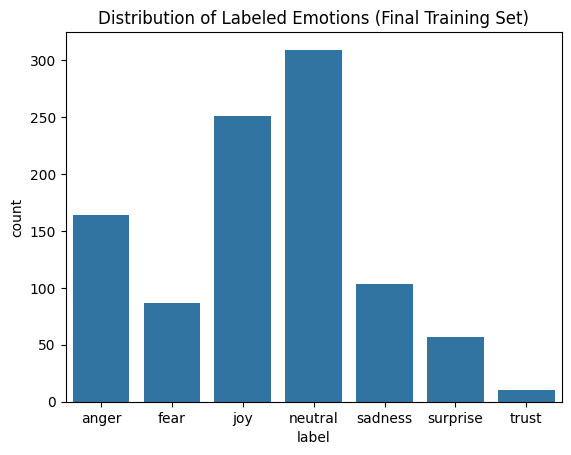

In [4]:
# Show labeled data (post-GPT + manual review)
df_labeled = pd.read_csv("../data/evaluation/emotion_verses_labeled.csv")
display(df_labeled.sample(5))
print(f"Total labeled verses: {len(df_labeled)}")

plt.figure()
sns.countplot(x="label", data=df_labeled, order=sorted(df_labeled['label'].unique()))
plt.title("Distribution of Labeled Emotions (Final Training Set)")
plt.show()

# 5️⃣ Fine-tuning SamLowe/roberta-base-go_emotions

## 4. Fine-tuning SamLowe/roberta-base-go_emotions on Custom Labeled Data

The fine-tuning uses 90% of the data for training and 10% for evaluation.  
Labels are mapped to integer IDs as required by HuggingFace.


We initialized the classification head (last layer) from scratch, as our label set consists of 7 mapped emotions, instead of the original 28 GoEmotions classes. The rest of the model loads all pre-trained weights, leveraging prior emotional knowledge. This is the recommended approach for transfer learning with a different output taxonomy.



In [ ]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import classification_report
from transformers import TrainingArguments


# 1. Load data
df = pd.read_csv("../data/evaluation/emotion_verses_labeled_combined.csv")
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

# 2. Define emotions and mapping
EMOTION_MAP = {
    "joy": "Alegría",
    "sadness": "Tristeza",
    "anger": "Ira",
    "fear": "Miedo",
    "surprise": "Sorpresa",
    "disgust": "Asco",
    "neutral": "Neutral"
}

label_list = list(EMOTION_MAP.keys())
label2id = {l: i for i, l in enumerate(label_list)}
id2label = {i: l for i, l in enumerate(label_list)}

# 3. Validate and map labels
df['label'] = df['label'].str.strip().str.lower()
invalid_labels = set(df['label'].unique()) - set(label_list)
if invalid_labels:
    print(f"❌ ERROR: Detected invalid labels: {invalid_labels}")
    raise ValueError("Your CSV contains labels not present in the expected set.")

df['label'] = df['label'].map(label2id).astype(int)

# 4. Split into train/test
split = int(len(df) * 0.9)
df_train = df.iloc[:split].copy()
df_test = df.iloc[split:].copy()

# 5. Build datasets
df_train['label'] = df_train['label'].astype(int)
df_test['label'] = df_test['label'].astype(int)
ds = DatasetDict({
    "train": Dataset.from_pandas(df_train[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
    "test": Dataset.from_pandas(df_test[['verse', 'label']].rename(columns={'verse': 'text'}), preserve_index=False),
})

# 6. Tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
model = AutoModelForSequenceClassification.from_pretrained(
    "SamLowe/roberta-base-go_emotions",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)
model.config.problem_type = "single_label_classification"  # <- Fuerza single-label

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True)

tokenized_datasets = ds.map(preprocess_function, batched=True)

# 7. Training arguments
training_args = TrainingArguments(
    output_dir="./results_finetuned_bible",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    num_train_epochs=10,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    greater_is_better=True,
    save_total_limit=2,
    logging_strategy="no",          # <<<<<< Cambia esto a "no"
    logging_steps=1000,             # (no afecta ya)
    report_to="none",
    seed=42,
    push_to_hub=False,
    disable_tqdm=True,              # <<<<<< Esto quita las barras de progreso
)

# 8. Metrics
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    labels = pred.label_ids
    report = classification_report(labels, preds, target_names=[id2label[i] for i in range(len(label_list))], output_dict=True, zero_division=0)
    macro_f1 = report["macro avg"]["f1-score"]
    return {"macro_f1": macro_f1}

# 9. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

trainer.train()
trainer.save_model("finetuned-goemotions-bible")

print("✅ Fine-tuning completed and model saved as 'finetuned-goemotions-bible/'")


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at SamLowe/roberta-base-go_emotions and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([28]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([28, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

Map: 100%|██████████| 1755/1755 [00:00<00:00, 20881.21 examples/s]

  0%|          | 6/2190 [00:00<04:53,  7.45it/s]

{'loss': 1.8626, 'grad_norm': 7.576636791229248, 'learning_rate': 4.5662100456621004e-07, 'epoch': 0.02}


  1%|          | 11/2190 [00:01<05:02,  7.20it/s]

{'loss': 1.9617, 'grad_norm': 14.131963729858398, 'learning_rate': 9.132420091324201e-07, 'epoch': 0.05}


  1%|          | 16/2190 [00:02<04:50,  7.48it/s]

{'loss': 2.0141, 'grad_norm': 6.877595901489258, 'learning_rate': 1.3698630136986302e-06, 'epoch': 0.07}


  1%|          | 21/2190 [00:02<04:57,  7.30it/s]

{'loss': 1.8862, 'grad_norm': 9.73044204711914, 'learning_rate': 1.8264840182648401e-06, 'epoch': 0.09}


  1%|          | 26/2190 [00:03<04:50,  7.45it/s]

{'loss': 1.8414, 'grad_norm': 12.617137908935547, 'learning_rate': 2.2831050228310503e-06, 'epoch': 0.11}


  1%|▏         | 31/2190 [00:04<04:47,  7.50it/s]

{'loss': 1.8364, 'grad_norm': 11.53805160522461, 'learning_rate': 2.7397260273972604e-06, 'epoch': 0.14}


  2%|▏         | 36/2190 [00:04<04:49,  7.45it/s]

{'loss': 1.9118, 'grad_norm': 8.897140502929688, 'learning_rate': 3.1963470319634706e-06, 'epoch': 0.16}


  2%|▏         | 41/2190 [00:05<04:45,  7.52it/s]

{'loss': 1.8191, 'grad_norm': 12.063325881958008, 'learning_rate': 3.6529680365296803e-06, 'epoch': 0.18}


  2%|▏         | 46/2190 [00:06<04:45,  7.52it/s]

{'loss': 1.9662, 'grad_norm': 7.51499080657959, 'learning_rate': 4.109589041095891e-06, 'epoch': 0.21}


  2%|▏         | 51/2190 [00:06<04:47,  7.45it/s]

{'loss': 1.9114, 'grad_norm': 10.377070426940918, 'learning_rate': 4.566210045662101e-06, 'epoch': 0.23}


  3%|▎         | 56/2190 [00:07<04:57,  7.18it/s]

{'loss': 1.8616, 'grad_norm': 9.173714637756348, 'learning_rate': 5.02283105022831e-06, 'epoch': 0.25}


  3%|▎         | 61/2190 [00:08<04:52,  7.28it/s]

{'loss': 1.8892, 'grad_norm': 10.348278999328613, 'learning_rate': 5.479452054794521e-06, 'epoch': 0.27}


  3%|▎         | 66/2190 [00:08<04:51,  7.29it/s]

{'loss': 1.7954, 'grad_norm': 9.079119682312012, 'learning_rate': 5.936073059360731e-06, 'epoch': 0.3}


  3%|▎         | 71/2190 [00:09<04:45,  7.41it/s]

{'loss': 1.6709, 'grad_norm': 9.859932899475098, 'learning_rate': 6.392694063926941e-06, 'epoch': 0.32}


  3%|▎         | 76/2190 [00:10<04:34,  7.70it/s]

{'loss': 1.8969, 'grad_norm': 10.015750885009766, 'learning_rate': 6.849315068493151e-06, 'epoch': 0.34}


  4%|▎         | 81/2190 [00:10<04:30,  7.80it/s]

{'loss': 1.7345, 'grad_norm': 11.067663192749023, 'learning_rate': 7.305936073059361e-06, 'epoch': 0.36}


  4%|▍         | 87/2190 [00:11<04:27,  7.87it/s]

{'loss': 1.7293, 'grad_norm': 10.329383850097656, 'learning_rate': 7.76255707762557e-06, 'epoch': 0.39}


  4%|▍         | 91/2190 [00:12<04:28,  7.81it/s]

{'loss': 1.6197, 'grad_norm': 8.73583984375, 'learning_rate': 8.219178082191782e-06, 'epoch': 0.41}


  4%|▍         | 96/2190 [00:12<04:28,  7.81it/s]

{'loss': 1.6977, 'grad_norm': 10.047222137451172, 'learning_rate': 8.675799086757991e-06, 'epoch': 0.43}


  5%|▍         | 102/2190 [00:13<04:21,  8.00it/s]

{'loss': 1.6412, 'grad_norm': 7.752480983734131, 'learning_rate': 9.132420091324201e-06, 'epoch': 0.46}


  5%|▍         | 106/2190 [00:14<04:21,  7.97it/s]

{'loss': 1.6338, 'grad_norm': 12.339106559753418, 'learning_rate': 9.589041095890411e-06, 'epoch': 0.48}


  5%|▌         | 111/2190 [00:14<04:27,  7.77it/s]

{'loss': 1.6354, 'grad_norm': 10.623042106628418, 'learning_rate': 1.004566210045662e-05, 'epoch': 0.5}


  5%|▌         | 116/2190 [00:15<04:29,  7.71it/s]

{'loss': 1.6205, 'grad_norm': 12.633193969726562, 'learning_rate': 1.0502283105022832e-05, 'epoch': 0.52}


  6%|▌         | 121/2190 [00:15<04:28,  7.71it/s]

{'loss': 1.4863, 'grad_norm': 11.057720184326172, 'learning_rate': 1.0958904109589042e-05, 'epoch': 0.55}


  6%|▌         | 126/2190 [00:16<04:27,  7.73it/s]

{'loss': 1.3773, 'grad_norm': 14.390859603881836, 'learning_rate': 1.1415525114155253e-05, 'epoch': 0.57}


  6%|▌         | 131/2190 [00:17<04:26,  7.73it/s]

{'loss': 1.4342, 'grad_norm': 16.482444763183594, 'learning_rate': 1.1872146118721461e-05, 'epoch': 0.59}


  6%|▌         | 136/2190 [00:17<04:26,  7.70it/s]

{'loss': 1.4336, 'grad_norm': 8.696734428405762, 'learning_rate': 1.2328767123287673e-05, 'epoch': 0.62}


  6%|▋         | 141/2190 [00:18<04:27,  7.66it/s]

{'loss': 1.5902, 'grad_norm': 21.425657272338867, 'learning_rate': 1.2785388127853882e-05, 'epoch': 0.64}


  7%|▋         | 146/2190 [00:19<04:24,  7.71it/s]

{'loss': 1.3505, 'grad_norm': 18.089021682739258, 'learning_rate': 1.3242009132420092e-05, 'epoch': 0.66}


  7%|▋         | 151/2190 [00:19<04:23,  7.73it/s]

{'loss': 1.626, 'grad_norm': 18.60603141784668, 'learning_rate': 1.3698630136986302e-05, 'epoch': 0.68}


  7%|▋         | 156/2190 [00:20<04:24,  7.69it/s]

{'loss': 1.6617, 'grad_norm': 23.659957885742188, 'learning_rate': 1.4155251141552513e-05, 'epoch': 0.71}


  7%|▋         | 161/2190 [00:21<04:21,  7.76it/s]

{'loss': 1.5512, 'grad_norm': 19.60167694091797, 'learning_rate': 1.4611872146118721e-05, 'epoch': 0.73}


  8%|▊         | 166/2190 [00:21<04:21,  7.75it/s]

{'loss': 1.329, 'grad_norm': 13.368475914001465, 'learning_rate': 1.5068493150684933e-05, 'epoch': 0.75}


  8%|▊         | 171/2190 [00:22<04:21,  7.72it/s]

{'loss': 1.4203, 'grad_norm': 17.085599899291992, 'learning_rate': 1.552511415525114e-05, 'epoch': 0.77}


  8%|▊         | 176/2190 [00:23<04:19,  7.77it/s]

{'loss': 1.4513, 'grad_norm': 15.501315116882324, 'learning_rate': 1.5981735159817352e-05, 'epoch': 0.8}


  8%|▊         | 181/2190 [00:23<04:21,  7.69it/s]

{'loss': 1.4741, 'grad_norm': 14.629030227661133, 'learning_rate': 1.6438356164383563e-05, 'epoch': 0.82}


  8%|▊         | 186/2190 [00:24<04:24,  7.57it/s]

{'loss': 1.6548, 'grad_norm': 17.635967254638672, 'learning_rate': 1.6894977168949775e-05, 'epoch': 0.84}


  9%|▊         | 191/2190 [00:25<04:22,  7.62it/s]

{'loss': 1.3852, 'grad_norm': 22.08030891418457, 'learning_rate': 1.7351598173515983e-05, 'epoch': 0.87}


  9%|▉         | 196/2190 [00:25<04:18,  7.72it/s]

{'loss': 1.4331, 'grad_norm': 23.44835090637207, 'learning_rate': 1.7808219178082194e-05, 'epoch': 0.89}


  9%|▉         | 201/2190 [00:26<04:16,  7.75it/s]

{'loss': 1.3626, 'grad_norm': 14.371895790100098, 'learning_rate': 1.8264840182648402e-05, 'epoch': 0.91}


  9%|▉         | 206/2190 [00:26<04:16,  7.75it/s]

{'loss': 1.2794, 'grad_norm': 20.221567153930664, 'learning_rate': 1.8721461187214614e-05, 'epoch': 0.93}


 10%|▉         | 211/2190 [00:27<04:15,  7.73it/s]

{'loss': 1.4729, 'grad_norm': 29.05735969543457, 'learning_rate': 1.9178082191780822e-05, 'epoch': 0.96}


 10%|▉         | 216/2190 [00:28<04:16,  7.69it/s]

{'loss': 1.2672, 'grad_norm': 13.392409324645996, 'learning_rate': 1.9634703196347033e-05, 'epoch': 0.98}


 10%|█         | 219/2190 [00:29<04:15,  7.73it/s]

{'eval_loss': 1.4885237216949463, 'eval_macro_f1': 0.36983894536222905, 'eval_runtime': 0.4055, 'eval_samples_per_second': 480.886, 'eval_steps_per_second': 61.652, 'epoch': 1.0}


 10%|█         | 221/2190 [00:30<17:20,  1.89it/s]

{'loss': 1.4321, 'grad_norm': 15.18757152557373, 'learning_rate': 1.9989852866565197e-05, 'epoch': 1.0}


 10%|█         | 226/2190 [00:31<06:26,  5.08it/s]

{'loss': 1.4861, 'grad_norm': 20.71542739868164, 'learning_rate': 1.9939117199391173e-05, 'epoch': 1.03}


 11%|█         | 231/2190 [00:32<04:39,  7.02it/s]

{'loss': 1.159, 'grad_norm': 14.705398559570312, 'learning_rate': 1.988838153221715e-05, 'epoch': 1.05}


 11%|█         | 236/2190 [00:32<04:16,  7.63it/s]

{'loss': 1.3728, 'grad_norm': 27.195547103881836, 'learning_rate': 1.9837645865043125e-05, 'epoch': 1.07}


 11%|█         | 241/2190 [00:33<04:13,  7.70it/s]

{'loss': 1.124, 'grad_norm': 14.536478996276855, 'learning_rate': 1.97869101978691e-05, 'epoch': 1.09}


 11%|█         | 246/2190 [00:34<04:10,  7.77it/s]

{'loss': 1.102, 'grad_norm': 19.78445816040039, 'learning_rate': 1.973617453069508e-05, 'epoch': 1.12}


 11%|█▏        | 251/2190 [00:34<04:11,  7.70it/s]

{'loss': 1.6114, 'grad_norm': 26.86455726623535, 'learning_rate': 1.9685438863521057e-05, 'epoch': 1.14}


 12%|█▏        | 256/2190 [00:35<04:10,  7.73it/s]

{'loss': 0.8774, 'grad_norm': 26.5090389251709, 'learning_rate': 1.9634703196347033e-05, 'epoch': 1.16}


 12%|█▏        | 261/2190 [00:36<04:08,  7.75it/s]

{'loss': 1.0306, 'grad_norm': 24.212711334228516, 'learning_rate': 1.958396752917301e-05, 'epoch': 1.18}


 12%|█▏        | 266/2190 [00:36<04:09,  7.70it/s]

{'loss': 1.1166, 'grad_norm': 21.8862247467041, 'learning_rate': 1.9533231861998985e-05, 'epoch': 1.21}


 12%|█▏        | 271/2190 [00:37<04:10,  7.67it/s]

{'loss': 1.3186, 'grad_norm': 14.282482147216797, 'learning_rate': 1.948249619482496e-05, 'epoch': 1.23}


 13%|█▎        | 276/2190 [00:37<04:07,  7.74it/s]

{'loss': 1.3429, 'grad_norm': 20.18143081665039, 'learning_rate': 1.943176052765094e-05, 'epoch': 1.25}


 13%|█▎        | 281/2190 [00:38<04:05,  7.77it/s]

{'loss': 1.2275, 'grad_norm': 11.515203475952148, 'learning_rate': 1.9381024860476917e-05, 'epoch': 1.28}


 13%|█▎        | 286/2190 [00:39<04:07,  7.69it/s]

{'loss': 1.0916, 'grad_norm': 18.064699172973633, 'learning_rate': 1.9330289193302893e-05, 'epoch': 1.3}


 13%|█▎        | 291/2190 [00:39<04:05,  7.72it/s]

{'loss': 1.2466, 'grad_norm': 26.3796329498291, 'learning_rate': 1.927955352612887e-05, 'epoch': 1.32}


 14%|█▎        | 296/2190 [00:40<04:06,  7.67it/s]

{'loss': 1.0786, 'grad_norm': 23.882261276245117, 'learning_rate': 1.9228817858954846e-05, 'epoch': 1.34}


 14%|█▎        | 301/2190 [00:41<04:04,  7.72it/s]

{'loss': 1.3269, 'grad_norm': 26.925048828125, 'learning_rate': 1.9178082191780822e-05, 'epoch': 1.37}


 14%|█▍        | 306/2190 [00:41<04:05,  7.68it/s]

{'loss': 1.2879, 'grad_norm': 16.502674102783203, 'learning_rate': 1.91273465246068e-05, 'epoch': 1.39}


 14%|█▍        | 311/2190 [00:42<04:01,  7.79it/s]

{'loss': 1.1908, 'grad_norm': 27.28435516357422, 'learning_rate': 1.9076610857432777e-05, 'epoch': 1.41}


 14%|█▍        | 316/2190 [00:43<04:08,  7.55it/s]

{'loss': 1.1858, 'grad_norm': 15.767900466918945, 'learning_rate': 1.9025875190258754e-05, 'epoch': 1.44}


 15%|█▍        | 321/2190 [00:43<04:05,  7.61it/s]

{'loss': 1.2551, 'grad_norm': 24.14870834350586, 'learning_rate': 1.897513952308473e-05, 'epoch': 1.46}


 15%|█▍        | 326/2190 [00:44<04:01,  7.71it/s]

{'loss': 1.342, 'grad_norm': 10.487702369689941, 'learning_rate': 1.8924403855910706e-05, 'epoch': 1.48}


 15%|█▌        | 331/2190 [00:45<04:00,  7.73it/s]

{'loss': 1.3407, 'grad_norm': 32.278175354003906, 'learning_rate': 1.8873668188736682e-05, 'epoch': 1.5}


 15%|█▌        | 336/2190 [00:45<04:01,  7.67it/s]

{'loss': 1.2298, 'grad_norm': 25.25012969970703, 'learning_rate': 1.882293252156266e-05, 'epoch': 1.53}


 16%|█▌        | 341/2190 [00:46<03:59,  7.71it/s]

{'loss': 0.882, 'grad_norm': 22.38966178894043, 'learning_rate': 1.8772196854388634e-05, 'epoch': 1.55}


 16%|█▌        | 346/2190 [00:47<03:58,  7.74it/s]

{'loss': 1.283, 'grad_norm': 33.34600067138672, 'learning_rate': 1.8721461187214614e-05, 'epoch': 1.57}


 16%|█▌        | 351/2190 [00:47<03:59,  7.67it/s]

{'loss': 1.0425, 'grad_norm': 18.880338668823242, 'learning_rate': 1.867072552004059e-05, 'epoch': 1.59}


 16%|█▋        | 356/2190 [00:48<03:58,  7.69it/s]

{'loss': 1.4929, 'grad_norm': 33.20363235473633, 'learning_rate': 1.8619989852866566e-05, 'epoch': 1.62}


 16%|█▋        | 361/2190 [00:49<03:58,  7.68it/s]

{'loss': 0.9345, 'grad_norm': 12.892239570617676, 'learning_rate': 1.8569254185692542e-05, 'epoch': 1.64}


 17%|█▋        | 366/2190 [00:49<03:57,  7.69it/s]

{'loss': 1.2733, 'grad_norm': 29.544240951538086, 'learning_rate': 1.851851851851852e-05, 'epoch': 1.66}


 17%|█▋        | 371/2190 [00:50<03:56,  7.68it/s]

{'loss': 1.4323, 'grad_norm': 33.17879867553711, 'learning_rate': 1.8467782851344494e-05, 'epoch': 1.69}


 17%|█▋        | 376/2190 [00:50<03:57,  7.64it/s]

{'loss': 1.3012, 'grad_norm': 44.42987823486328, 'learning_rate': 1.8417047184170474e-05, 'epoch': 1.71}


 17%|█▋        | 381/2190 [00:51<03:54,  7.71it/s]

{'loss': 1.1654, 'grad_norm': 25.624526977539062, 'learning_rate': 1.836631151699645e-05, 'epoch': 1.73}


 18%|█▊        | 386/2190 [00:52<03:59,  7.52it/s]

{'loss': 1.2168, 'grad_norm': 39.56350326538086, 'learning_rate': 1.8315575849822426e-05, 'epoch': 1.75}


 18%|█▊        | 391/2190 [00:52<03:54,  7.69it/s]

{'loss': 1.5547, 'grad_norm': 20.492965698242188, 'learning_rate': 1.8264840182648402e-05, 'epoch': 1.78}


 18%|█▊        | 396/2190 [00:53<03:51,  7.74it/s]

{'loss': 0.9875, 'grad_norm': 15.910360336303711, 'learning_rate': 1.821410451547438e-05, 'epoch': 1.8}


 18%|█▊        | 401/2190 [00:54<03:50,  7.76it/s]

{'loss': 1.1004, 'grad_norm': 21.01563262939453, 'learning_rate': 1.8163368848300355e-05, 'epoch': 1.82}


 19%|█▊        | 406/2190 [00:54<03:49,  7.77it/s]

{'loss': 1.051, 'grad_norm': 27.34149742126465, 'learning_rate': 1.8112633181126334e-05, 'epoch': 1.85}


 19%|█▉        | 411/2190 [00:55<03:51,  7.70it/s]

{'loss': 1.1279, 'grad_norm': 25.267789840698242, 'learning_rate': 1.806189751395231e-05, 'epoch': 1.87}


 19%|█▉        | 416/2190 [00:56<03:50,  7.71it/s]

{'loss': 1.0219, 'grad_norm': 18.581418991088867, 'learning_rate': 1.8011161846778286e-05, 'epoch': 1.89}


 19%|█▉        | 421/2190 [00:56<03:49,  7.71it/s]

{'loss': 1.4589, 'grad_norm': 22.037137985229492, 'learning_rate': 1.7960426179604263e-05, 'epoch': 1.91}


 19%|█▉        | 426/2190 [00:57<03:49,  7.69it/s]

{'loss': 0.9937, 'grad_norm': 14.96922779083252, 'learning_rate': 1.790969051243024e-05, 'epoch': 1.94}


 20%|█▉        | 431/2190 [00:58<03:49,  7.65it/s]

{'loss': 0.9567, 'grad_norm': 26.47012710571289, 'learning_rate': 1.7858954845256215e-05, 'epoch': 1.96}


 20%|█▉        | 436/2190 [00:58<03:56,  7.43it/s]

{'loss': 1.1105, 'grad_norm': 21.56749725341797, 'learning_rate': 1.7808219178082194e-05, 'epoch': 1.98}


 20%|██        | 439/2190 [00:59<04:00,  7.28it/s]

{'eval_loss': 1.4518119096755981, 'eval_macro_f1': 0.45374169690703176, 'eval_runtime': 0.4478, 'eval_samples_per_second': 435.422, 'eval_steps_per_second': 55.823, 'epoch': 2.0}


 20%|██        | 441/2190 [01:01<16:09,  1.80it/s]

{'loss': 0.9405, 'grad_norm': 20.168115615844727, 'learning_rate': 1.775748351090817e-05, 'epoch': 2.0}


 20%|██        | 446/2190 [01:02<05:49,  4.98it/s]

{'loss': 0.8659, 'grad_norm': 43.6892204284668, 'learning_rate': 1.7706747843734147e-05, 'epoch': 2.03}


 21%|██        | 451/2190 [01:02<04:05,  7.09it/s]

{'loss': 0.8312, 'grad_norm': 38.39006042480469, 'learning_rate': 1.7656012176560123e-05, 'epoch': 2.05}


 21%|██        | 456/2190 [01:03<03:48,  7.60it/s]

{'loss': 1.0921, 'grad_norm': 52.4235725402832, 'learning_rate': 1.76052765093861e-05, 'epoch': 2.07}


 21%|██        | 461/2190 [01:04<03:45,  7.66it/s]

{'loss': 0.8035, 'grad_norm': 21.819242477416992, 'learning_rate': 1.7554540842212075e-05, 'epoch': 2.1}


 21%|██▏       | 466/2190 [01:04<03:44,  7.66it/s]

{'loss': 0.7955, 'grad_norm': 14.458165168762207, 'learning_rate': 1.7503805175038054e-05, 'epoch': 2.12}


 22%|██▏       | 471/2190 [01:05<03:42,  7.73it/s]

{'loss': 0.7503, 'grad_norm': 17.193204879760742, 'learning_rate': 1.7453069507864027e-05, 'epoch': 2.14}


 22%|██▏       | 476/2190 [01:06<03:40,  7.77it/s]

{'loss': 0.91, 'grad_norm': 26.42612648010254, 'learning_rate': 1.7402333840690007e-05, 'epoch': 2.16}


 22%|██▏       | 481/2190 [01:06<03:40,  7.76it/s]

{'loss': 1.2023, 'grad_norm': 27.907312393188477, 'learning_rate': 1.7351598173515983e-05, 'epoch': 2.19}


 22%|██▏       | 486/2190 [01:07<03:41,  7.69it/s]

{'loss': 0.8264, 'grad_norm': 23.669307708740234, 'learning_rate': 1.730086250634196e-05, 'epoch': 2.21}


 22%|██▏       | 491/2190 [01:07<03:40,  7.71it/s]

{'loss': 0.6973, 'grad_norm': 20.004892349243164, 'learning_rate': 1.7250126839167935e-05, 'epoch': 2.23}


 23%|██▎       | 496/2190 [01:08<03:39,  7.71it/s]

{'loss': 0.5312, 'grad_norm': 6.390602111816406, 'learning_rate': 1.7199391171993915e-05, 'epoch': 2.26}


 23%|██▎       | 501/2190 [01:09<03:54,  7.19it/s]

{'loss': 0.8383, 'grad_norm': 19.385337829589844, 'learning_rate': 1.7148655504819887e-05, 'epoch': 2.28}


 23%|██▎       | 506/2190 [01:10<04:08,  6.77it/s]

{'loss': 0.9552, 'grad_norm': 37.86018753051758, 'learning_rate': 1.7097919837645867e-05, 'epoch': 2.3}


 23%|██▎       | 511/2190 [01:10<03:42,  7.56it/s]

{'loss': 1.0386, 'grad_norm': 27.81105613708496, 'learning_rate': 1.7047184170471843e-05, 'epoch': 2.32}


 24%|██▎       | 516/2190 [01:11<03:39,  7.62it/s]

{'loss': 0.8849, 'grad_norm': 25.293743133544922, 'learning_rate': 1.699644850329782e-05, 'epoch': 2.35}


 24%|██▍       | 521/2190 [01:11<03:37,  7.67it/s]

{'loss': 1.0532, 'grad_norm': 28.539045333862305, 'learning_rate': 1.6945712836123795e-05, 'epoch': 2.37}


 24%|██▍       | 526/2190 [01:12<03:36,  7.70it/s]

{'loss': 0.912, 'grad_norm': 19.688749313354492, 'learning_rate': 1.6894977168949775e-05, 'epoch': 2.39}


 24%|██▍       | 531/2190 [01:13<03:34,  7.74it/s]

{'loss': 0.8864, 'grad_norm': 47.35800552368164, 'learning_rate': 1.6844241501775748e-05, 'epoch': 2.41}


 24%|██▍       | 536/2190 [01:13<03:34,  7.71it/s]

{'loss': 0.7776, 'grad_norm': 27.362384796142578, 'learning_rate': 1.6793505834601727e-05, 'epoch': 2.44}


 25%|██▍       | 541/2190 [01:14<03:35,  7.66it/s]

{'loss': 0.755, 'grad_norm': 20.37139129638672, 'learning_rate': 1.6742770167427703e-05, 'epoch': 2.46}


 25%|██▍       | 546/2190 [01:15<03:32,  7.73it/s]

{'loss': 0.9398, 'grad_norm': 15.749934196472168, 'learning_rate': 1.669203450025368e-05, 'epoch': 2.48}


 25%|██▌       | 551/2190 [01:15<03:32,  7.70it/s]

{'loss': 0.8738, 'grad_norm': 34.6598014831543, 'learning_rate': 1.6641298833079656e-05, 'epoch': 2.51}


 25%|██▌       | 556/2190 [01:16<03:31,  7.72it/s]

{'loss': 1.1414, 'grad_norm': 34.71861267089844, 'learning_rate': 1.659056316590563e-05, 'epoch': 2.53}


 26%|██▌       | 561/2190 [01:17<03:32,  7.68it/s]

{'loss': 1.0281, 'grad_norm': 46.96400451660156, 'learning_rate': 1.6539827498731608e-05, 'epoch': 2.55}


 26%|██▌       | 566/2190 [01:17<03:31,  7.68it/s]

{'loss': 0.7464, 'grad_norm': 20.876752853393555, 'learning_rate': 1.6489091831557587e-05, 'epoch': 2.57}


 26%|██▌       | 571/2190 [01:18<03:30,  7.68it/s]

{'loss': 0.9214, 'grad_norm': 22.731124877929688, 'learning_rate': 1.6438356164383563e-05, 'epoch': 2.6}


 26%|██▋       | 576/2190 [01:19<03:29,  7.72it/s]

{'loss': 0.864, 'grad_norm': 33.49516677856445, 'learning_rate': 1.638762049720954e-05, 'epoch': 2.62}


 27%|██▋       | 581/2190 [01:19<03:30,  7.65it/s]

{'loss': 0.7584, 'grad_norm': 42.878902435302734, 'learning_rate': 1.6336884830035516e-05, 'epoch': 2.64}


 27%|██▋       | 586/2190 [01:20<03:26,  7.76it/s]

{'loss': 0.686, 'grad_norm': 11.788576126098633, 'learning_rate': 1.6286149162861492e-05, 'epoch': 2.67}


 27%|██▋       | 591/2190 [01:21<03:27,  7.72it/s]

{'loss': 0.9767, 'grad_norm': 34.700042724609375, 'learning_rate': 1.6235413495687468e-05, 'epoch': 2.69}


 27%|██▋       | 596/2190 [01:21<03:26,  7.74it/s]

{'loss': 1.0021, 'grad_norm': 30.57362174987793, 'learning_rate': 1.6184677828513448e-05, 'epoch': 2.71}


 27%|██▋       | 601/2190 [01:22<03:28,  7.62it/s]

{'loss': 0.838, 'grad_norm': 17.32560157775879, 'learning_rate': 1.6133942161339424e-05, 'epoch': 2.73}


 28%|██▊       | 606/2190 [01:23<03:25,  7.70it/s]

{'loss': 0.7018, 'grad_norm': 32.016265869140625, 'learning_rate': 1.60832064941654e-05, 'epoch': 2.76}


 28%|██▊       | 611/2190 [01:23<03:26,  7.64it/s]

{'loss': 0.7228, 'grad_norm': 54.519248962402344, 'learning_rate': 1.6032470826991376e-05, 'epoch': 2.78}


 28%|██▊       | 616/2190 [01:24<03:24,  7.71it/s]

{'loss': 0.7677, 'grad_norm': 41.188907623291016, 'learning_rate': 1.5981735159817352e-05, 'epoch': 2.8}


 28%|██▊       | 621/2190 [01:24<03:23,  7.71it/s]

{'loss': 1.0435, 'grad_norm': 39.06098556518555, 'learning_rate': 1.5930999492643328e-05, 'epoch': 2.82}


 29%|██▊       | 626/2190 [01:25<03:24,  7.67it/s]

{'loss': 1.0661, 'grad_norm': 19.524309158325195, 'learning_rate': 1.5880263825469308e-05, 'epoch': 2.85}


 29%|██▉       | 631/2190 [01:26<03:24,  7.64it/s]

{'loss': 0.5807, 'grad_norm': 23.843280792236328, 'learning_rate': 1.582952815829528e-05, 'epoch': 2.87}


 29%|██▉       | 636/2190 [01:26<03:21,  7.70it/s]

{'loss': 0.8663, 'grad_norm': 40.397674560546875, 'learning_rate': 1.577879249112126e-05, 'epoch': 2.89}


 29%|██▉       | 641/2190 [01:27<03:24,  7.56it/s]

{'loss': 0.7514, 'grad_norm': 32.803165435791016, 'learning_rate': 1.5728056823947236e-05, 'epoch': 2.92}


 29%|██▉       | 646/2190 [01:28<03:24,  7.56it/s]

{'loss': 0.7091, 'grad_norm': 16.957534790039062, 'learning_rate': 1.5677321156773212e-05, 'epoch': 2.94}


 30%|██▉       | 651/2190 [01:28<03:20,  7.69it/s]

{'loss': 0.7827, 'grad_norm': 31.677494049072266, 'learning_rate': 1.562658548959919e-05, 'epoch': 2.96}


 30%|██▉       | 656/2190 [01:29<03:19,  7.67it/s]

{'loss': 0.8091, 'grad_norm': 23.680082321166992, 'learning_rate': 1.5575849822425168e-05, 'epoch': 2.98}


 30%|███       | 658/2190 [01:30<03:26,  7.43it/s]

{'eval_loss': 1.5142005681991577, 'eval_macro_f1': 0.4457580500227385, 'eval_runtime': 0.4047, 'eval_samples_per_second': 481.867, 'eval_steps_per_second': 61.778, 'epoch': 3.0}


 30%|███       | 661/2190 [01:31<10:02,  2.54it/s]

{'loss': 0.7449, 'grad_norm': 36.37506866455078, 'learning_rate': 1.552511415525114e-05, 'epoch': 3.01}


 30%|███       | 666/2190 [01:32<04:27,  5.69it/s]

{'loss': 0.7539, 'grad_norm': 35.70560073852539, 'learning_rate': 1.547437848807712e-05, 'epoch': 3.03}


 31%|███       | 671/2190 [01:33<03:31,  7.18it/s]

{'loss': 0.4194, 'grad_norm': 20.513334274291992, 'learning_rate': 1.5423642820903096e-05, 'epoch': 3.05}


 31%|███       | 676/2190 [01:33<03:17,  7.65it/s]

{'loss': 0.4957, 'grad_norm': 30.84404754638672, 'learning_rate': 1.5372907153729072e-05, 'epoch': 3.08}


 31%|███       | 682/2190 [01:34<03:13,  7.81it/s]

{'loss': 0.5584, 'grad_norm': 29.788175582885742, 'learning_rate': 1.532217148655505e-05, 'epoch': 3.1}


 31%|███▏      | 686/2190 [01:35<03:13,  7.77it/s]

{'loss': 0.6088, 'grad_norm': 50.415016174316406, 'learning_rate': 1.5271435819381025e-05, 'epoch': 3.12}


 32%|███▏      | 691/2190 [01:35<03:13,  7.75it/s]

{'loss': 0.449, 'grad_norm': 45.034820556640625, 'learning_rate': 1.5220700152207003e-05, 'epoch': 3.14}


 32%|███▏      | 696/2190 [01:36<03:12,  7.74it/s]

{'loss': 0.8471, 'grad_norm': 36.198856353759766, 'learning_rate': 1.516996448503298e-05, 'epoch': 3.17}


 32%|███▏      | 701/2190 [01:37<03:14,  7.66it/s]

{'loss': 0.7918, 'grad_norm': 30.4541072845459, 'learning_rate': 1.5119228817858955e-05, 'epoch': 3.19}


 32%|███▏      | 706/2190 [01:37<03:12,  7.69it/s]

{'loss': 0.4733, 'grad_norm': 39.23805618286133, 'learning_rate': 1.5068493150684933e-05, 'epoch': 3.21}


 32%|███▏      | 711/2190 [01:38<03:12,  7.70it/s]

{'loss': 0.64, 'grad_norm': 30.022857666015625, 'learning_rate': 1.5017757483510909e-05, 'epoch': 3.23}


 33%|███▎      | 716/2190 [01:39<03:11,  7.69it/s]

{'loss': 0.5863, 'grad_norm': 24.004592895507812, 'learning_rate': 1.4967021816336887e-05, 'epoch': 3.26}


 33%|███▎      | 721/2190 [01:39<03:11,  7.66it/s]

{'loss': 0.4622, 'grad_norm': 14.872274398803711, 'learning_rate': 1.4916286149162863e-05, 'epoch': 3.28}


 33%|███▎      | 726/2190 [01:40<03:08,  7.78it/s]

{'loss': 0.7896, 'grad_norm': 29.5008602142334, 'learning_rate': 1.4865550481988839e-05, 'epoch': 3.3}


 33%|███▎      | 731/2190 [01:41<03:09,  7.71it/s]

{'loss': 0.3257, 'grad_norm': 19.43733024597168, 'learning_rate': 1.4814814814814815e-05, 'epoch': 3.33}


 34%|███▎      | 736/2190 [01:41<03:05,  7.83it/s]

{'loss': 0.7237, 'grad_norm': 104.26881408691406, 'learning_rate': 1.4764079147640793e-05, 'epoch': 3.35}


 34%|███▍      | 741/2190 [01:42<03:07,  7.71it/s]

{'loss': 0.54, 'grad_norm': 48.81917190551758, 'learning_rate': 1.4713343480466769e-05, 'epoch': 3.37}


 34%|███▍      | 746/2190 [01:42<03:06,  7.75it/s]

{'loss': 1.0098, 'grad_norm': 22.9085636138916, 'learning_rate': 1.4662607813292747e-05, 'epoch': 3.39}


 34%|███▍      | 751/2190 [01:43<03:06,  7.71it/s]

{'loss': 0.4715, 'grad_norm': 29.983707427978516, 'learning_rate': 1.4611872146118721e-05, 'epoch': 3.42}


 35%|███▍      | 756/2190 [01:44<03:05,  7.75it/s]

{'loss': 0.4827, 'grad_norm': 24.368412017822266, 'learning_rate': 1.4561136478944699e-05, 'epoch': 3.44}


 35%|███▍      | 761/2190 [01:44<03:05,  7.71it/s]

{'loss': 0.3992, 'grad_norm': 22.4058780670166, 'learning_rate': 1.4510400811770675e-05, 'epoch': 3.46}


 35%|███▍      | 766/2190 [01:45<03:09,  7.51it/s]

{'loss': 0.5336, 'grad_norm': 29.580310821533203, 'learning_rate': 1.4459665144596653e-05, 'epoch': 3.49}


 35%|███▌      | 771/2190 [01:46<03:05,  7.64it/s]

{'loss': 0.5778, 'grad_norm': 41.313350677490234, 'learning_rate': 1.4408929477422629e-05, 'epoch': 3.51}


 35%|███▌      | 776/2190 [01:46<03:02,  7.74it/s]

{'loss': 0.5511, 'grad_norm': 22.691667556762695, 'learning_rate': 1.4358193810248607e-05, 'epoch': 3.53}


 36%|███▌      | 781/2190 [01:47<03:04,  7.64it/s]

{'loss': 0.6194, 'grad_norm': 30.497928619384766, 'learning_rate': 1.4307458143074581e-05, 'epoch': 3.55}


 36%|███▌      | 786/2190 [01:48<03:06,  7.52it/s]

{'loss': 0.3445, 'grad_norm': 24.166004180908203, 'learning_rate': 1.425672247590056e-05, 'epoch': 3.58}


 36%|███▌      | 791/2190 [01:48<03:01,  7.70it/s]

{'loss': 0.6761, 'grad_norm': 32.12734603881836, 'learning_rate': 1.4205986808726535e-05, 'epoch': 3.6}


 36%|███▋      | 796/2190 [01:49<03:01,  7.68it/s]

{'loss': 0.7667, 'grad_norm': 24.501068115234375, 'learning_rate': 1.4155251141552513e-05, 'epoch': 3.62}


 37%|███▋      | 801/2190 [01:50<03:00,  7.70it/s]

{'loss': 0.6547, 'grad_norm': 53.18717575073242, 'learning_rate': 1.410451547437849e-05, 'epoch': 3.64}


 37%|███▋      | 806/2190 [01:50<02:58,  7.74it/s]

{'loss': 0.6173, 'grad_norm': 30.528438568115234, 'learning_rate': 1.4053779807204465e-05, 'epoch': 3.67}


 37%|███▋      | 811/2190 [01:51<02:59,  7.69it/s]

{'loss': 0.7581, 'grad_norm': 9.640787124633789, 'learning_rate': 1.4003044140030442e-05, 'epoch': 3.69}


 37%|███▋      | 816/2190 [01:52<02:59,  7.65it/s]

{'loss': 0.5075, 'grad_norm': 18.35437774658203, 'learning_rate': 1.395230847285642e-05, 'epoch': 3.71}


 37%|███▋      | 821/2190 [01:52<02:56,  7.76it/s]

{'loss': 0.4911, 'grad_norm': 16.59099006652832, 'learning_rate': 1.3901572805682396e-05, 'epoch': 3.74}


 38%|███▊      | 826/2190 [01:53<02:55,  7.76it/s]

{'loss': 0.6994, 'grad_norm': 17.1170654296875, 'learning_rate': 1.3850837138508373e-05, 'epoch': 3.76}


 38%|███▊      | 831/2190 [01:54<02:56,  7.68it/s]

{'loss': 0.3927, 'grad_norm': 12.994377136230469, 'learning_rate': 1.3800101471334348e-05, 'epoch': 3.78}


 38%|███▊      | 836/2190 [01:54<02:55,  7.70it/s]

{'loss': 1.0071, 'grad_norm': 35.25450134277344, 'learning_rate': 1.3749365804160326e-05, 'epoch': 3.8}


 38%|███▊      | 841/2190 [01:55<02:54,  7.71it/s]

{'loss': 0.4545, 'grad_norm': 24.33229637145996, 'learning_rate': 1.3698630136986302e-05, 'epoch': 3.83}


 39%|███▊      | 846/2190 [01:56<02:54,  7.68it/s]

{'loss': 0.7149, 'grad_norm': 20.487533569335938, 'learning_rate': 1.364789446981228e-05, 'epoch': 3.85}


 39%|███▉      | 851/2190 [01:56<02:52,  7.74it/s]

{'loss': 0.391, 'grad_norm': 43.80424118041992, 'learning_rate': 1.3597158802638256e-05, 'epoch': 3.87}


 39%|███▉      | 856/2190 [01:57<02:52,  7.73it/s]

{'loss': 0.5452, 'grad_norm': 12.401676177978516, 'learning_rate': 1.3546423135464234e-05, 'epoch': 3.9}


 39%|███▉      | 861/2190 [01:57<02:52,  7.70it/s]

{'loss': 0.9171, 'grad_norm': 30.16974449157715, 'learning_rate': 1.3495687468290208e-05, 'epoch': 3.92}


 40%|███▉      | 866/2190 [01:58<02:52,  7.69it/s]

{'loss': 0.7865, 'grad_norm': 20.381607055664062, 'learning_rate': 1.3444951801116186e-05, 'epoch': 3.94}


 40%|███▉      | 871/2190 [01:59<02:53,  7.61it/s]

{'loss': 0.705, 'grad_norm': 19.9063777923584, 'learning_rate': 1.3394216133942162e-05, 'epoch': 3.96}


 40%|████      | 876/2190 [01:59<02:49,  7.74it/s]

{'loss': 0.5631, 'grad_norm': 7.14935827255249, 'learning_rate': 1.334348046676814e-05, 'epoch': 3.99}


 40%|████      | 878/2190 [02:00<02:49,  7.73it/s]

{'eval_loss': 1.6730597019195557, 'eval_macro_f1': 0.45033615675193545, 'eval_runtime': 0.4361, 'eval_samples_per_second': 447.146, 'eval_steps_per_second': 57.326, 'epoch': 4.0}


 40%|████      | 881/2190 [02:02<08:36,  2.54it/s]

{'loss': 0.6876, 'grad_norm': 24.962785720825195, 'learning_rate': 1.3292744799594114e-05, 'epoch': 4.01}


 40%|████      | 886/2190 [02:02<03:47,  5.73it/s]

{'loss': 0.4944, 'grad_norm': 37.86720275878906, 'learning_rate': 1.3242009132420092e-05, 'epoch': 4.03}


 41%|████      | 891/2190 [02:03<02:58,  7.29it/s]

{'loss': 0.4175, 'grad_norm': 6.325650691986084, 'learning_rate': 1.3191273465246068e-05, 'epoch': 4.05}


 41%|████      | 896/2190 [02:04<02:55,  7.39it/s]

{'loss': 0.7097, 'grad_norm': 15.703697204589844, 'learning_rate': 1.3140537798072046e-05, 'epoch': 4.08}


 41%|████      | 901/2190 [02:04<02:47,  7.68it/s]

{'loss': 0.4012, 'grad_norm': 6.686856269836426, 'learning_rate': 1.3089802130898022e-05, 'epoch': 4.1}


 41%|████▏     | 906/2190 [02:05<02:51,  7.50it/s]

{'loss': 0.5797, 'grad_norm': 10.49366569519043, 'learning_rate': 1.3039066463724e-05, 'epoch': 4.12}


 42%|████▏     | 911/2190 [02:06<02:48,  7.59it/s]

{'loss': 0.3017, 'grad_norm': 9.522256851196289, 'learning_rate': 1.2988330796549974e-05, 'epoch': 4.15}


 42%|████▏     | 916/2190 [02:06<02:44,  7.72it/s]

{'loss': 0.4615, 'grad_norm': 33.407100677490234, 'learning_rate': 1.2937595129375952e-05, 'epoch': 4.17}


 42%|████▏     | 921/2190 [02:07<02:45,  7.66it/s]

{'loss': 0.4234, 'grad_norm': 72.39058685302734, 'learning_rate': 1.2886859462201928e-05, 'epoch': 4.19}


 42%|████▏     | 926/2190 [02:08<02:43,  7.73it/s]

{'loss': 0.3725, 'grad_norm': 64.26563262939453, 'learning_rate': 1.2836123795027906e-05, 'epoch': 4.21}


 43%|████▎     | 931/2190 [02:08<02:42,  7.77it/s]

{'loss': 0.239, 'grad_norm': 5.601303577423096, 'learning_rate': 1.2785388127853882e-05, 'epoch': 4.24}


 43%|████▎     | 936/2190 [02:09<02:41,  7.78it/s]

{'loss': 0.433, 'grad_norm': 21.523195266723633, 'learning_rate': 1.273465246067986e-05, 'epoch': 4.26}


 43%|████▎     | 941/2190 [02:10<02:41,  7.74it/s]

{'loss': 0.2964, 'grad_norm': 32.41996383666992, 'learning_rate': 1.2683916793505835e-05, 'epoch': 4.28}


 43%|████▎     | 946/2190 [02:10<02:42,  7.67it/s]

{'loss': 0.2927, 'grad_norm': 8.244964599609375, 'learning_rate': 1.2633181126331812e-05, 'epoch': 4.31}


 43%|████▎     | 951/2190 [02:11<02:40,  7.73it/s]

{'loss': 0.3841, 'grad_norm': 23.52631950378418, 'learning_rate': 1.2582445459157789e-05, 'epoch': 4.33}


 44%|████▎     | 956/2190 [02:12<02:42,  7.59it/s]

{'loss': 0.3498, 'grad_norm': 3.9754037857055664, 'learning_rate': 1.2531709791983766e-05, 'epoch': 4.35}


 44%|████▍     | 961/2190 [02:12<02:40,  7.64it/s]

{'loss': 0.4847, 'grad_norm': 34.00843048095703, 'learning_rate': 1.248097412480974e-05, 'epoch': 4.37}


 44%|████▍     | 966/2190 [02:13<02:39,  7.69it/s]

{'loss': 0.3929, 'grad_norm': 35.874183654785156, 'learning_rate': 1.2430238457635719e-05, 'epoch': 4.4}


 44%|████▍     | 971/2190 [02:14<02:37,  7.72it/s]

{'loss': 0.2954, 'grad_norm': 23.45392608642578, 'learning_rate': 1.2379502790461695e-05, 'epoch': 4.42}


 45%|████▍     | 976/2190 [02:14<02:38,  7.68it/s]

{'loss': 0.1735, 'grad_norm': 25.714305877685547, 'learning_rate': 1.2328767123287673e-05, 'epoch': 4.44}


 45%|████▍     | 981/2190 [02:15<02:37,  7.69it/s]

{'loss': 0.5899, 'grad_norm': 37.17839050292969, 'learning_rate': 1.2278031456113649e-05, 'epoch': 4.46}


 45%|████▌     | 986/2190 [02:16<02:36,  7.67it/s]

{'loss': 0.3298, 'grad_norm': 1.5922592878341675, 'learning_rate': 1.2227295788939627e-05, 'epoch': 4.49}


 45%|████▌     | 991/2190 [02:16<02:34,  7.78it/s]

{'loss': 0.2247, 'grad_norm': 7.1810173988342285, 'learning_rate': 1.2176560121765601e-05, 'epoch': 4.51}


 45%|████▌     | 996/2190 [02:17<02:34,  7.71it/s]

{'loss': 0.5245, 'grad_norm': 27.036304473876953, 'learning_rate': 1.2125824454591579e-05, 'epoch': 4.53}


 46%|████▌     | 1001/2190 [02:17<02:35,  7.67it/s]

{'loss': 0.493, 'grad_norm': 62.084659576416016, 'learning_rate': 1.2075088787417555e-05, 'epoch': 4.56}


 46%|████▌     | 1006/2190 [02:18<02:36,  7.54it/s]

{'loss': 0.3325, 'grad_norm': 27.58548927307129, 'learning_rate': 1.2024353120243533e-05, 'epoch': 4.58}


 46%|████▌     | 1011/2190 [02:19<02:33,  7.67it/s]

{'loss': 0.347, 'grad_norm': 21.377866744995117, 'learning_rate': 1.1973617453069509e-05, 'epoch': 4.6}


 46%|████▋     | 1016/2190 [02:19<02:33,  7.64it/s]

{'loss': 0.5354, 'grad_norm': 65.89909362792969, 'learning_rate': 1.1922881785895487e-05, 'epoch': 4.62}


 47%|████▋     | 1021/2190 [02:20<02:32,  7.68it/s]

{'loss': 0.3231, 'grad_norm': 7.205692291259766, 'learning_rate': 1.1872146118721461e-05, 'epoch': 4.65}


 47%|████▋     | 1026/2190 [02:21<02:30,  7.72it/s]

{'loss': 0.6794, 'grad_norm': 43.26128387451172, 'learning_rate': 1.1821410451547439e-05, 'epoch': 4.67}


 47%|████▋     | 1031/2190 [02:21<02:29,  7.75it/s]

{'loss': 0.3917, 'grad_norm': 3.131441831588745, 'learning_rate': 1.1770674784373415e-05, 'epoch': 4.69}


 47%|████▋     | 1036/2190 [02:22<02:30,  7.69it/s]

{'loss': 0.5623, 'grad_norm': 4.934340476989746, 'learning_rate': 1.1719939117199393e-05, 'epoch': 4.72}


 48%|████▊     | 1041/2190 [02:23<02:29,  7.66it/s]

{'loss': 0.2732, 'grad_norm': 13.31369686126709, 'learning_rate': 1.1669203450025367e-05, 'epoch': 4.74}


 48%|████▊     | 1046/2190 [02:23<02:28,  7.70it/s]

{'loss': 0.4239, 'grad_norm': 33.0633544921875, 'learning_rate': 1.1618467782851345e-05, 'epoch': 4.76}


 48%|████▊     | 1051/2190 [02:24<02:28,  7.67it/s]

{'loss': 0.3554, 'grad_norm': 52.23971939086914, 'learning_rate': 1.1567732115677321e-05, 'epoch': 4.78}


 48%|████▊     | 1056/2190 [02:25<02:29,  7.61it/s]

{'loss': 0.3612, 'grad_norm': 37.12111282348633, 'learning_rate': 1.15169964485033e-05, 'epoch': 4.81}


 48%|████▊     | 1061/2190 [02:25<02:27,  7.66it/s]

{'loss': 0.1471, 'grad_norm': 21.583961486816406, 'learning_rate': 1.1466260781329275e-05, 'epoch': 4.83}


 49%|████▊     | 1066/2190 [02:26<02:25,  7.75it/s]

{'loss': 0.3833, 'grad_norm': 24.0378475189209, 'learning_rate': 1.1415525114155253e-05, 'epoch': 4.85}


 49%|████▉     | 1071/2190 [02:27<02:26,  7.63it/s]

{'loss': 0.4694, 'grad_norm': 32.8402214050293, 'learning_rate': 1.1364789446981228e-05, 'epoch': 4.87}


 49%|████▉     | 1076/2190 [02:27<02:26,  7.63it/s]

{'loss': 0.2202, 'grad_norm': 4.654304027557373, 'learning_rate': 1.1314053779807205e-05, 'epoch': 4.9}


 49%|████▉     | 1081/2190 [02:28<02:24,  7.68it/s]

{'loss': 0.3459, 'grad_norm': 29.189620971679688, 'learning_rate': 1.1263318112633182e-05, 'epoch': 4.92}


 50%|████▉     | 1086/2190 [02:29<02:23,  7.69it/s]

{'loss': 0.2222, 'grad_norm': 125.8316879272461, 'learning_rate': 1.121258244545916e-05, 'epoch': 4.94}


 50%|████▉     | 1091/2190 [02:29<02:22,  7.73it/s]

{'loss': 0.4566, 'grad_norm': 15.643879890441895, 'learning_rate': 1.1161846778285136e-05, 'epoch': 4.97}


 50%|█████     | 1096/2190 [02:30<02:22,  7.67it/s]

{'loss': 0.531, 'grad_norm': 44.31221389770508, 'learning_rate': 1.1111111111111113e-05, 'epoch': 4.99}


 50%|█████     | 1097/2190 [02:30<02:21,  7.70it/s]

{'eval_loss': 1.863263726234436, 'eval_macro_f1': 0.4849680837743501, 'eval_runtime': 0.4132, 'eval_samples_per_second': 471.907, 'eval_steps_per_second': 60.501, 'epoch': 5.0}


 50%|█████     | 1101/2190 [02:32<05:46,  3.14it/s]

{'loss': 0.312, 'grad_norm': 16.78860092163086, 'learning_rate': 1.1060375443937088e-05, 'epoch': 5.01}


 51%|█████     | 1106/2190 [02:33<02:53,  6.23it/s]

{'loss': 0.1411, 'grad_norm': 8.903301239013672, 'learning_rate': 1.1009639776763066e-05, 'epoch': 5.03}


 51%|█████     | 1111/2190 [02:34<02:24,  7.45it/s]

{'loss': 0.2327, 'grad_norm': 43.38290023803711, 'learning_rate': 1.0958904109589042e-05, 'epoch': 5.06}


 51%|█████     | 1116/2190 [02:34<02:19,  7.70it/s]

{'loss': 0.4449, 'grad_norm': 39.81332778930664, 'learning_rate': 1.090816844241502e-05, 'epoch': 5.08}


 51%|█████     | 1121/2190 [02:35<02:20,  7.62it/s]

{'loss': 0.1384, 'grad_norm': 1.5943920612335205, 'learning_rate': 1.0857432775240994e-05, 'epoch': 5.1}


 51%|█████▏    | 1126/2190 [02:36<02:17,  7.72it/s]

{'loss': 0.2133, 'grad_norm': 11.017914772033691, 'learning_rate': 1.0806697108066972e-05, 'epoch': 5.13}


 52%|█████▏    | 1131/2190 [02:36<02:17,  7.73it/s]

{'loss': 0.1806, 'grad_norm': 28.32696533203125, 'learning_rate': 1.0755961440892948e-05, 'epoch': 5.15}


 52%|█████▏    | 1136/2190 [02:37<02:22,  7.42it/s]

{'loss': 0.3983, 'grad_norm': 3.721686840057373, 'learning_rate': 1.0705225773718926e-05, 'epoch': 5.17}


 52%|█████▏    | 1141/2190 [02:38<02:17,  7.61it/s]

{'loss': 0.3347, 'grad_norm': 9.756645202636719, 'learning_rate': 1.0654490106544902e-05, 'epoch': 5.19}


 52%|█████▏    | 1146/2190 [02:38<02:16,  7.64it/s]

{'loss': 0.1866, 'grad_norm': 12.548657417297363, 'learning_rate': 1.060375443937088e-05, 'epoch': 5.22}


 53%|█████▎    | 1151/2190 [02:39<02:14,  7.71it/s]

{'loss': 0.2511, 'grad_norm': 28.872285842895508, 'learning_rate': 1.0553018772196854e-05, 'epoch': 5.24}


 53%|█████▎    | 1156/2190 [02:39<02:15,  7.65it/s]

{'loss': 0.2519, 'grad_norm': 7.111577987670898, 'learning_rate': 1.0502283105022832e-05, 'epoch': 5.26}


 53%|█████▎    | 1161/2190 [02:40<02:32,  6.76it/s]

{'loss': 0.2328, 'grad_norm': 41.854515075683594, 'learning_rate': 1.0451547437848808e-05, 'epoch': 5.28}


 53%|█████▎    | 1166/2190 [02:41<02:17,  7.43it/s]

{'loss': 0.1716, 'grad_norm': 1.6711751222610474, 'learning_rate': 1.0400811770674786e-05, 'epoch': 5.31}


 53%|█████▎    | 1171/2190 [02:42<02:12,  7.72it/s]

{'loss': 0.0934, 'grad_norm': 3.3541786670684814, 'learning_rate': 1.0350076103500762e-05, 'epoch': 5.33}


 54%|█████▎    | 1177/2190 [02:42<02:11,  7.69it/s]

{'loss': 0.215, 'grad_norm': 0.5115430951118469, 'learning_rate': 1.0299340436326738e-05, 'epoch': 5.35}


 54%|█████▍    | 1181/2190 [02:43<02:12,  7.61it/s]

{'loss': 0.3286, 'grad_norm': 48.33269500732422, 'learning_rate': 1.0248604769152714e-05, 'epoch': 5.38}


 54%|█████▍    | 1186/2190 [02:44<02:13,  7.49it/s]

{'loss': 0.2321, 'grad_norm': 53.38530731201172, 'learning_rate': 1.0197869101978692e-05, 'epoch': 5.4}


 54%|█████▍    | 1191/2190 [02:44<02:10,  7.65it/s]

{'loss': 0.2017, 'grad_norm': 58.77338790893555, 'learning_rate': 1.0147133434804668e-05, 'epoch': 5.42}


 55%|█████▍    | 1196/2190 [02:45<02:15,  7.31it/s]

{'loss': 0.0878, 'grad_norm': 15.198419570922852, 'learning_rate': 1.0096397767630646e-05, 'epoch': 5.44}


 55%|█████▍    | 1201/2190 [02:45<02:09,  7.62it/s]

{'loss': 0.2051, 'grad_norm': 10.001347541809082, 'learning_rate': 1.004566210045662e-05, 'epoch': 5.47}


 55%|█████▌    | 1206/2190 [02:46<02:10,  7.54it/s]

{'loss': 0.4827, 'grad_norm': 43.38463592529297, 'learning_rate': 9.994926433282598e-06, 'epoch': 5.49}


 55%|█████▌    | 1211/2190 [02:47<02:08,  7.63it/s]

{'loss': 0.2306, 'grad_norm': 44.671058654785156, 'learning_rate': 9.944190766108575e-06, 'epoch': 5.51}


 56%|█████▌    | 1216/2190 [02:47<02:07,  7.66it/s]

{'loss': 0.1787, 'grad_norm': 15.318293571472168, 'learning_rate': 9.89345509893455e-06, 'epoch': 5.54}


 56%|█████▌    | 1221/2190 [02:48<02:05,  7.72it/s]

{'loss': 0.0993, 'grad_norm': 3.0169179439544678, 'learning_rate': 9.842719431760529e-06, 'epoch': 5.56}


 56%|█████▌    | 1226/2190 [02:49<02:06,  7.60it/s]

{'loss': 0.3693, 'grad_norm': 33.92584228515625, 'learning_rate': 9.791983764586505e-06, 'epoch': 5.58}


 56%|█████▌    | 1231/2190 [02:49<02:03,  7.73it/s]

{'loss': 0.1445, 'grad_norm': 43.57393264770508, 'learning_rate': 9.74124809741248e-06, 'epoch': 5.6}


 56%|█████▋    | 1236/2190 [02:50<02:04,  7.64it/s]

{'loss': 0.3034, 'grad_norm': 3.770662784576416, 'learning_rate': 9.690512430238459e-06, 'epoch': 5.63}


 57%|█████▋    | 1241/2190 [02:51<02:02,  7.76it/s]

{'loss': 0.2222, 'grad_norm': 11.65147876739502, 'learning_rate': 9.639776763064435e-06, 'epoch': 5.65}


 57%|█████▋    | 1247/2190 [02:51<02:00,  7.81it/s]

{'loss': 0.5823, 'grad_norm': 90.3542251586914, 'learning_rate': 9.589041095890411e-06, 'epoch': 5.67}


 57%|█████▋    | 1251/2190 [02:52<02:01,  7.73it/s]

{'loss': 0.3864, 'grad_norm': 74.18589782714844, 'learning_rate': 9.538305428716389e-06, 'epoch': 5.69}


 57%|█████▋    | 1256/2190 [02:53<02:00,  7.74it/s]

{'loss': 0.1653, 'grad_norm': 85.6987533569336, 'learning_rate': 9.487569761542365e-06, 'epoch': 5.72}


 58%|█████▊    | 1261/2190 [02:53<01:58,  7.81it/s]

{'loss': 0.2567, 'grad_norm': 27.548505783081055, 'learning_rate': 9.436834094368341e-06, 'epoch': 5.74}


 58%|█████▊    | 1266/2190 [02:54<01:57,  7.89it/s]

{'loss': 0.4111, 'grad_norm': 0.24150674045085907, 'learning_rate': 9.386098427194317e-06, 'epoch': 5.76}


 58%|█████▊    | 1271/2190 [02:55<01:58,  7.78it/s]

{'loss': 0.3141, 'grad_norm': 35.480350494384766, 'learning_rate': 9.335362760020295e-06, 'epoch': 5.79}


 58%|█████▊    | 1276/2190 [02:55<02:00,  7.61it/s]

{'loss': 0.3147, 'grad_norm': 39.79525375366211, 'learning_rate': 9.284627092846271e-06, 'epoch': 5.81}


 58%|█████▊    | 1281/2190 [02:56<01:56,  7.77it/s]

{'loss': 0.2842, 'grad_norm': 91.43464660644531, 'learning_rate': 9.233891425672247e-06, 'epoch': 5.83}


 59%|█████▊    | 1286/2190 [02:56<01:55,  7.83it/s]

{'loss': 0.2322, 'grad_norm': 59.71509552001953, 'learning_rate': 9.183155758498225e-06, 'epoch': 5.85}


 59%|█████▉    | 1291/2190 [02:57<01:56,  7.69it/s]

{'loss': 0.0869, 'grad_norm': 4.541818618774414, 'learning_rate': 9.132420091324201e-06, 'epoch': 5.88}


 59%|█████▉    | 1296/2190 [02:58<01:55,  7.77it/s]

{'loss': 0.5664, 'grad_norm': 25.027523040771484, 'learning_rate': 9.081684424150177e-06, 'epoch': 5.9}


 59%|█████▉    | 1301/2190 [02:58<02:02,  7.25it/s]

{'loss': 0.5093, 'grad_norm': 37.69818115234375, 'learning_rate': 9.030948756976155e-06, 'epoch': 5.92}


 60%|█████▉    | 1307/2190 [02:59<01:55,  7.67it/s]

{'loss': 0.1589, 'grad_norm': 14.813577651977539, 'learning_rate': 8.980213089802131e-06, 'epoch': 5.95}


 60%|█████▉    | 1311/2190 [03:00<01:54,  7.65it/s]

{'loss': 0.3309, 'grad_norm': 2.467190980911255, 'learning_rate': 8.929477422628107e-06, 'epoch': 5.97}


 60%|██████    | 1316/2190 [03:00<01:52,  7.76it/s]

{'loss': 0.0765, 'grad_norm': 0.9742392897605896, 'learning_rate': 8.878741755454085e-06, 'epoch': 5.99}


 60%|██████    | 1317/2190 [03:01<01:53,  7.66it/s]

{'eval_loss': 2.2811336517333984, 'eval_macro_f1': 0.48168098904931833, 'eval_runtime': 0.4352, 'eval_samples_per_second': 448.079, 'eval_steps_per_second': 57.446, 'epoch': 6.0}


 60%|██████    | 1321/2190 [03:03<04:32,  3.18it/s]

{'loss': 0.0847, 'grad_norm': 44.63552474975586, 'learning_rate': 8.828006088280061e-06, 'epoch': 6.01}


 61%|██████    | 1327/2190 [03:04<02:08,  6.72it/s]

{'loss': 0.1951, 'grad_norm': 29.307327270507812, 'learning_rate': 8.777270421106037e-06, 'epoch': 6.04}


 61%|██████    | 1331/2190 [03:04<01:54,  7.50it/s]

{'loss': 0.0286, 'grad_norm': 6.008581161499023, 'learning_rate': 8.726534753932014e-06, 'epoch': 6.06}


 61%|██████    | 1336/2190 [03:05<01:49,  7.77it/s]

{'loss': 0.1574, 'grad_norm': 0.33111315965652466, 'learning_rate': 8.675799086757991e-06, 'epoch': 6.08}


 61%|██████    | 1341/2190 [03:05<01:48,  7.79it/s]

{'loss': 0.4233, 'grad_norm': 8.978361129760742, 'learning_rate': 8.625063419583968e-06, 'epoch': 6.1}


 61%|██████▏   | 1346/2190 [03:06<01:48,  7.77it/s]

{'loss': 0.0464, 'grad_norm': 1.27549409866333, 'learning_rate': 8.574327752409944e-06, 'epoch': 6.13}


 62%|██████▏   | 1351/2190 [03:07<01:47,  7.80it/s]

{'loss': 0.3351, 'grad_norm': 0.1673797369003296, 'learning_rate': 8.523592085235922e-06, 'epoch': 6.15}


 62%|██████▏   | 1356/2190 [03:07<01:46,  7.82it/s]

{'loss': 0.0441, 'grad_norm': 1.123267650604248, 'learning_rate': 8.472856418061898e-06, 'epoch': 6.17}


 62%|██████▏   | 1361/2190 [03:08<01:47,  7.75it/s]

{'loss': 0.3302, 'grad_norm': 17.437755584716797, 'learning_rate': 8.422120750887874e-06, 'epoch': 6.2}


 62%|██████▏   | 1366/2190 [03:09<01:47,  7.69it/s]

{'loss': 0.1918, 'grad_norm': 23.08319664001465, 'learning_rate': 8.371385083713852e-06, 'epoch': 6.22}


 63%|██████▎   | 1371/2190 [03:09<01:44,  7.80it/s]

{'loss': 0.2426, 'grad_norm': 0.191344752907753, 'learning_rate': 8.320649416539828e-06, 'epoch': 6.24}


 63%|██████▎   | 1376/2190 [03:10<01:57,  6.95it/s]

{'loss': 0.0984, 'grad_norm': 17.860580444335938, 'learning_rate': 8.269913749365804e-06, 'epoch': 6.26}


 63%|██████▎   | 1381/2190 [03:11<01:53,  7.16it/s]

{'loss': 0.1019, 'grad_norm': 100.09090423583984, 'learning_rate': 8.219178082191782e-06, 'epoch': 6.29}


 63%|██████▎   | 1386/2190 [03:11<01:44,  7.69it/s]

{'loss': 0.2143, 'grad_norm': 2.754185676574707, 'learning_rate': 8.168442415017758e-06, 'epoch': 6.31}


 64%|██████▎   | 1391/2190 [03:12<01:42,  7.82it/s]

{'loss': 0.1611, 'grad_norm': 13.874074935913086, 'learning_rate': 8.117706747843734e-06, 'epoch': 6.33}


 64%|██████▎   | 1396/2190 [03:13<01:41,  7.82it/s]

{'loss': 0.3426, 'grad_norm': 65.92634582519531, 'learning_rate': 8.066971080669712e-06, 'epoch': 6.36}


 64%|██████▍   | 1402/2190 [03:13<01:41,  7.79it/s]

{'loss': 0.108, 'grad_norm': 3.206895589828491, 'learning_rate': 8.016235413495688e-06, 'epoch': 6.38}


 64%|██████▍   | 1406/2190 [03:14<01:40,  7.78it/s]

{'loss': 0.2912, 'grad_norm': 4.944882392883301, 'learning_rate': 7.965499746321664e-06, 'epoch': 6.4}


 64%|██████▍   | 1412/2190 [03:15<01:39,  7.84it/s]

{'loss': 0.0765, 'grad_norm': 0.17356278002262115, 'learning_rate': 7.91476407914764e-06, 'epoch': 6.42}


 65%|██████▍   | 1416/2190 [03:15<01:40,  7.70it/s]

{'loss': 0.245, 'grad_norm': 127.572509765625, 'learning_rate': 7.864028411973618e-06, 'epoch': 6.45}


 65%|██████▍   | 1421/2190 [03:16<01:38,  7.77it/s]

{'loss': 0.2788, 'grad_norm': 124.96845245361328, 'learning_rate': 7.813292744799594e-06, 'epoch': 6.47}


 65%|██████▌   | 1426/2190 [03:16<01:39,  7.69it/s]

{'loss': 0.3862, 'grad_norm': 14.290148735046387, 'learning_rate': 7.76255707762557e-06, 'epoch': 6.49}


 65%|██████▌   | 1431/2190 [03:17<01:37,  7.76it/s]

{'loss': 0.211, 'grad_norm': 17.37926483154297, 'learning_rate': 7.711821410451548e-06, 'epoch': 6.51}


 66%|██████▌   | 1436/2190 [03:18<01:37,  7.76it/s]

{'loss': 0.2152, 'grad_norm': 6.947320938110352, 'learning_rate': 7.661085743277524e-06, 'epoch': 6.54}


 66%|██████▌   | 1441/2190 [03:18<01:36,  7.75it/s]

{'loss': 0.1924, 'grad_norm': 58.030643463134766, 'learning_rate': 7.610350076103501e-06, 'epoch': 6.56}


 66%|██████▌   | 1446/2190 [03:19<01:35,  7.78it/s]

{'loss': 0.3979, 'grad_norm': 0.16776470839977264, 'learning_rate': 7.559614408929477e-06, 'epoch': 6.58}


 66%|██████▋   | 1451/2190 [03:20<01:34,  7.85it/s]

{'loss': 0.1273, 'grad_norm': 74.29039764404297, 'learning_rate': 7.508878741755454e-06, 'epoch': 6.61}


 67%|██████▋   | 1457/2190 [03:20<01:33,  7.83it/s]

{'loss': 0.1965, 'grad_norm': 0.8963298201560974, 'learning_rate': 7.458143074581431e-06, 'epoch': 6.63}


 67%|██████▋   | 1461/2190 [03:21<01:34,  7.74it/s]

{'loss': 0.0179, 'grad_norm': 6.874514102935791, 'learning_rate': 7.4074074074074075e-06, 'epoch': 6.65}


 67%|██████▋   | 1466/2190 [03:22<01:32,  7.80it/s]

{'loss': 0.2717, 'grad_norm': 6.010084629058838, 'learning_rate': 7.3566717402333845e-06, 'epoch': 6.67}


 67%|██████▋   | 1471/2190 [03:22<01:32,  7.79it/s]

{'loss': 0.5083, 'grad_norm': 20.591938018798828, 'learning_rate': 7.305936073059361e-06, 'epoch': 6.7}


 67%|██████▋   | 1476/2190 [03:23<01:30,  7.86it/s]

{'loss': 0.0273, 'grad_norm': 23.775646209716797, 'learning_rate': 7.2552004058853376e-06, 'epoch': 6.72}


 68%|██████▊   | 1481/2190 [03:23<01:30,  7.84it/s]

{'loss': 0.2165, 'grad_norm': 62.236053466796875, 'learning_rate': 7.2044647387113146e-06, 'epoch': 6.74}


 68%|██████▊   | 1486/2190 [03:24<01:30,  7.80it/s]

{'loss': 0.2153, 'grad_norm': 6.7138590812683105, 'learning_rate': 7.153729071537291e-06, 'epoch': 6.77}


 68%|██████▊   | 1491/2190 [03:25<01:29,  7.83it/s]

{'loss': 0.0143, 'grad_norm': 2.3702383041381836, 'learning_rate': 7.102993404363268e-06, 'epoch': 6.79}


 68%|██████▊   | 1496/2190 [03:25<01:28,  7.84it/s]

{'loss': 0.1314, 'grad_norm': 96.31629943847656, 'learning_rate': 7.052257737189245e-06, 'epoch': 6.81}


 69%|██████▊   | 1501/2190 [03:26<01:28,  7.81it/s]

{'loss': 0.0116, 'grad_norm': 3.0118753910064697, 'learning_rate': 7.001522070015221e-06, 'epoch': 6.83}


 69%|██████▉   | 1506/2190 [03:27<01:27,  7.85it/s]

{'loss': 0.136, 'grad_norm': 1.4713056087493896, 'learning_rate': 6.950786402841198e-06, 'epoch': 6.86}


 69%|██████▉   | 1511/2190 [03:27<01:27,  7.76it/s]

{'loss': 0.0292, 'grad_norm': 0.2792172133922577, 'learning_rate': 6.900050735667174e-06, 'epoch': 6.88}


 69%|██████▉   | 1516/2190 [03:28<01:30,  7.47it/s]

{'loss': 0.0712, 'grad_norm': 0.4277338683605194, 'learning_rate': 6.849315068493151e-06, 'epoch': 6.9}


 69%|██████▉   | 1521/2190 [03:29<01:26,  7.71it/s]

{'loss': 0.0603, 'grad_norm': 0.1471230685710907, 'learning_rate': 6.798579401319128e-06, 'epoch': 6.92}


 70%|██████▉   | 1526/2190 [03:29<01:25,  7.80it/s]

{'loss': 0.1341, 'grad_norm': 0.6161210536956787, 'learning_rate': 6.747843734145104e-06, 'epoch': 6.95}


 70%|██████▉   | 1531/2190 [03:30<01:24,  7.79it/s]

{'loss': 0.2857, 'grad_norm': 75.2291488647461, 'learning_rate': 6.697108066971081e-06, 'epoch': 6.97}


 70%|███████   | 1536/2190 [03:30<01:24,  7.78it/s]

{'loss': 0.1063, 'grad_norm': 16.566835403442383, 'learning_rate': 6.646372399797057e-06, 'epoch': 6.99}



 70%|███████   | 1536/2190 [03:31<01:24,  7.78it/s]

{'eval_loss': 2.539795160293579, 'eval_macro_f1': 0.48228724403831924, 'eval_runtime': 0.4021, 'eval_samples_per_second': 484.99, 'eval_steps_per_second': 62.178, 'epoch': 7.0}


 70%|███████   | 1541/2190 [03:33<02:50,  3.80it/s]

{'loss': 0.0112, 'grad_norm': 0.12739640474319458, 'learning_rate': 6.595636732623034e-06, 'epoch': 7.02}


 71%|███████   | 1547/2190 [03:34<01:31,  7.00it/s]

{'loss': 0.1192, 'grad_norm': 2.6223068237304688, 'learning_rate': 6.544901065449011e-06, 'epoch': 7.04}


 71%|███████   | 1551/2190 [03:34<01:24,  7.60it/s]

{'loss': 0.039, 'grad_norm': 20.141889572143555, 'learning_rate': 6.494165398274987e-06, 'epoch': 7.06}


 71%|███████   | 1556/2190 [03:35<01:21,  7.75it/s]

{'loss': 0.0069, 'grad_norm': 1.5772515535354614, 'learning_rate': 6.443429731100964e-06, 'epoch': 7.08}


 71%|███████▏  | 1561/2190 [03:36<01:20,  7.84it/s]

{'loss': 0.0299, 'grad_norm': 3.0113489627838135, 'learning_rate': 6.392694063926941e-06, 'epoch': 7.11}


 72%|███████▏  | 1566/2190 [03:36<01:19,  7.80it/s]

{'loss': 0.0805, 'grad_norm': 0.7635523080825806, 'learning_rate': 6.341958396752917e-06, 'epoch': 7.13}


 72%|███████▏  | 1571/2190 [03:37<01:19,  7.76it/s]

{'loss': 0.1333, 'grad_norm': 19.905303955078125, 'learning_rate': 6.291222729578894e-06, 'epoch': 7.15}


 72%|███████▏  | 1576/2190 [03:37<01:19,  7.74it/s]

{'loss': 0.0581, 'grad_norm': 1.4018245935440063, 'learning_rate': 6.24048706240487e-06, 'epoch': 7.18}


 72%|███████▏  | 1581/2190 [03:38<01:17,  7.82it/s]

{'loss': 0.0425, 'grad_norm': 0.21335004270076752, 'learning_rate': 6.189751395230847e-06, 'epoch': 7.2}


 72%|███████▏  | 1586/2190 [03:39<01:18,  7.74it/s]

{'loss': 0.1834, 'grad_norm': 5.08814811706543, 'learning_rate': 6.139015728056824e-06, 'epoch': 7.22}


 73%|███████▎  | 1591/2190 [03:39<01:17,  7.74it/s]

{'loss': 0.3023, 'grad_norm': 34.73640823364258, 'learning_rate': 6.0882800608828005e-06, 'epoch': 7.24}


 73%|███████▎  | 1596/2190 [03:40<01:26,  6.83it/s]

{'loss': 0.192, 'grad_norm': 0.32934805750846863, 'learning_rate': 6.0375443937087775e-06, 'epoch': 7.27}


 73%|███████▎  | 1601/2190 [03:41<01:18,  7.48it/s]

{'loss': 0.4108, 'grad_norm': 27.07549285888672, 'learning_rate': 5.9868087265347545e-06, 'epoch': 7.29}


 73%|███████▎  | 1606/2190 [03:41<01:15,  7.79it/s]

{'loss': 0.2125, 'grad_norm': 120.13279724121094, 'learning_rate': 5.936073059360731e-06, 'epoch': 7.31}


 74%|███████▎  | 1612/2190 [03:42<01:14,  7.76it/s]

{'loss': 0.0491, 'grad_norm': 3.761699914932251, 'learning_rate': 5.8853373921867076e-06, 'epoch': 7.33}


 74%|███████▍  | 1616/2190 [03:43<01:13,  7.78it/s]

{'loss': 0.0385, 'grad_norm': 3.7804954051971436, 'learning_rate': 5.834601725012684e-06, 'epoch': 7.36}


 74%|███████▍  | 1621/2190 [03:43<01:12,  7.81it/s]

{'loss': 0.159, 'grad_norm': 5.661421298980713, 'learning_rate': 5.783866057838661e-06, 'epoch': 7.38}


 74%|███████▍  | 1626/2190 [03:44<01:11,  7.84it/s]

{'loss': 0.1945, 'grad_norm': 98.08016967773438, 'learning_rate': 5.733130390664638e-06, 'epoch': 7.4}


 74%|███████▍  | 1631/2190 [03:45<01:11,  7.81it/s]

{'loss': 0.2538, 'grad_norm': 0.3322977125644684, 'learning_rate': 5.682394723490614e-06, 'epoch': 7.43}


 75%|███████▍  | 1636/2190 [03:45<01:11,  7.78it/s]

{'loss': 0.1104, 'grad_norm': 0.811779797077179, 'learning_rate': 5.631659056316591e-06, 'epoch': 7.45}


 75%|███████▍  | 1642/2190 [03:46<01:09,  7.83it/s]

{'loss': 0.3026, 'grad_norm': 0.4460943937301636, 'learning_rate': 5.580923389142568e-06, 'epoch': 7.47}


 75%|███████▌  | 1646/2190 [03:47<01:09,  7.82it/s]

{'loss': 0.0568, 'grad_norm': 41.27154541015625, 'learning_rate': 5.530187721968544e-06, 'epoch': 7.49}


 75%|███████▌  | 1651/2190 [03:47<01:09,  7.77it/s]

{'loss': 0.0113, 'grad_norm': 0.1793839931488037, 'learning_rate': 5.479452054794521e-06, 'epoch': 7.52}


 76%|███████▌  | 1656/2190 [03:48<01:08,  7.82it/s]

{'loss': 0.0247, 'grad_norm': 0.1214175894856453, 'learning_rate': 5.428716387620497e-06, 'epoch': 7.54}


 76%|███████▌  | 1661/2190 [03:48<01:07,  7.79it/s]

{'loss': 0.0133, 'grad_norm': 10.973918914794922, 'learning_rate': 5.377980720446474e-06, 'epoch': 7.56}


 76%|███████▌  | 1666/2190 [03:49<01:07,  7.74it/s]

{'loss': 0.0607, 'grad_norm': 0.4027210474014282, 'learning_rate': 5.327245053272451e-06, 'epoch': 7.59}


 76%|███████▋  | 1672/2190 [03:50<01:06,  7.80it/s]

{'loss': 0.0116, 'grad_norm': 0.10056985169649124, 'learning_rate': 5.276509386098427e-06, 'epoch': 7.61}


 77%|███████▋  | 1676/2190 [03:50<01:06,  7.77it/s]

{'loss': 0.1109, 'grad_norm': 3.205888509750366, 'learning_rate': 5.225773718924404e-06, 'epoch': 7.63}


 77%|███████▋  | 1681/2190 [03:51<01:04,  7.87it/s]

{'loss': 0.2528, 'grad_norm': 15.495044708251953, 'learning_rate': 5.175038051750381e-06, 'epoch': 7.65}


 77%|███████▋  | 1686/2190 [03:52<01:04,  7.83it/s]

{'loss': 0.0132, 'grad_norm': 2.024705410003662, 'learning_rate': 5.124302384576357e-06, 'epoch': 7.68}


 77%|███████▋  | 1691/2190 [03:52<01:04,  7.79it/s]

{'loss': 0.0439, 'grad_norm': 0.45498210191726685, 'learning_rate': 5.073566717402334e-06, 'epoch': 7.7}


 77%|███████▋  | 1696/2190 [03:53<01:03,  7.84it/s]

{'loss': 0.1066, 'grad_norm': 110.18295288085938, 'learning_rate': 5.02283105022831e-06, 'epoch': 7.72}


 78%|███████▊  | 1701/2190 [03:54<01:02,  7.84it/s]

{'loss': 0.0734, 'grad_norm': 0.42325523495674133, 'learning_rate': 4.972095383054287e-06, 'epoch': 7.74}


 78%|███████▊  | 1707/2190 [03:54<01:01,  7.86it/s]

{'loss': 0.1005, 'grad_norm': 0.31300535798072815, 'learning_rate': 4.921359715880264e-06, 'epoch': 7.77}


 78%|███████▊  | 1711/2190 [03:55<01:01,  7.77it/s]

{'loss': 0.0631, 'grad_norm': 21.580318450927734, 'learning_rate': 4.87062404870624e-06, 'epoch': 7.79}


 78%|███████▊  | 1717/2190 [03:56<01:00,  7.83it/s]

{'loss': 0.1377, 'grad_norm': 2.277895927429199, 'learning_rate': 4.819888381532217e-06, 'epoch': 7.81}


 79%|███████▊  | 1721/2190 [03:56<00:59,  7.83it/s]

{'loss': 0.0939, 'grad_norm': 382.9912414550781, 'learning_rate': 4.769152714358194e-06, 'epoch': 7.84}


 79%|███████▉  | 1726/2190 [03:57<00:59,  7.85it/s]

{'loss': 0.1993, 'grad_norm': 9.322209358215332, 'learning_rate': 4.7184170471841705e-06, 'epoch': 7.86}


 79%|███████▉  | 1731/2190 [03:57<00:58,  7.79it/s]

{'loss': 0.2168, 'grad_norm': 0.29755380749702454, 'learning_rate': 4.6676813800101475e-06, 'epoch': 7.88}


 79%|███████▉  | 1737/2190 [03:58<00:58,  7.73it/s]

{'loss': 0.2233, 'grad_norm': 34.72659683227539, 'learning_rate': 4.616945712836124e-06, 'epoch': 7.9}


 79%|███████▉  | 1741/2190 [03:59<00:58,  7.62it/s]

{'loss': 0.0435, 'grad_norm': 60.86779022216797, 'learning_rate': 4.566210045662101e-06, 'epoch': 7.93}


 80%|███████▉  | 1746/2190 [03:59<00:57,  7.78it/s]

{'loss': 0.1913, 'grad_norm': 43.17171096801758, 'learning_rate': 4.5154743784880776e-06, 'epoch': 7.95}


 80%|███████▉  | 1751/2190 [04:00<00:56,  7.83it/s]

{'loss': 0.2315, 'grad_norm': 66.60704040527344, 'learning_rate': 4.464738711314054e-06, 'epoch': 7.97}


 80%|████████  | 1756/2190 [04:01<00:55,  7.86it/s]

{'loss': 0.1954, 'grad_norm': 20.297752380371094, 'learning_rate': 4.414003044140031e-06, 'epoch': 8.0}



 80%|████████  | 1756/2190 [04:01<00:55,  7.86it/s]

{'eval_loss': 2.636152744293213, 'eval_macro_f1': 0.49281835309564687, 'eval_runtime': 0.4381, 'eval_samples_per_second': 445.143, 'eval_steps_per_second': 57.07, 'epoch': 8.0}


 80%|████████  | 1761/2190 [04:03<01:51,  3.85it/s]

{'loss': 0.1456, 'grad_norm': 0.27839523553848267, 'learning_rate': 4.363267376966007e-06, 'epoch': 8.02}


 81%|████████  | 1766/2190 [04:04<01:03,  6.71it/s]

{'loss': 0.1088, 'grad_norm': 0.7754102349281311, 'learning_rate': 4.312531709791984e-06, 'epoch': 8.04}


 81%|████████  | 1771/2190 [04:04<00:55,  7.56it/s]

{'loss': 0.1957, 'grad_norm': 97.41682434082031, 'learning_rate': 4.261796042617961e-06, 'epoch': 8.06}


 81%|████████  | 1776/2190 [04:05<00:53,  7.69it/s]

{'loss': 0.0048, 'grad_norm': 1.949131727218628, 'learning_rate': 4.211060375443937e-06, 'epoch': 8.09}


 81%|████████▏ | 1781/2190 [04:06<00:52,  7.79it/s]

{'loss': 0.1949, 'grad_norm': 22.854228973388672, 'learning_rate': 4.160324708269914e-06, 'epoch': 8.11}


 82%|████████▏ | 1786/2190 [04:06<00:51,  7.80it/s]

{'loss': 0.1132, 'grad_norm': 0.18695995211601257, 'learning_rate': 4.109589041095891e-06, 'epoch': 8.13}


 82%|████████▏ | 1791/2190 [04:07<00:51,  7.74it/s]

{'loss': 0.1632, 'grad_norm': 36.001312255859375, 'learning_rate': 4.058853373921867e-06, 'epoch': 8.15}


 82%|████████▏ | 1796/2190 [04:08<00:50,  7.78it/s]

{'loss': 0.0352, 'grad_norm': 0.06730209290981293, 'learning_rate': 4.008117706747844e-06, 'epoch': 8.18}


 82%|████████▏ | 1801/2190 [04:08<00:53,  7.32it/s]

{'loss': 0.1926, 'grad_norm': 0.13994146883487701, 'learning_rate': 3.95738203957382e-06, 'epoch': 8.2}


 82%|████████▏ | 1806/2190 [04:09<00:56,  6.74it/s]

{'loss': 0.1594, 'grad_norm': 0.2580670714378357, 'learning_rate': 3.906646372399797e-06, 'epoch': 8.22}


 83%|████████▎ | 1811/2190 [04:10<00:53,  7.05it/s]

{'loss': 0.2137, 'grad_norm': 0.07087244838476181, 'learning_rate': 3.855910705225774e-06, 'epoch': 8.25}


 83%|████████▎ | 1817/2190 [04:10<00:47,  7.77it/s]

{'loss': 0.1939, 'grad_norm': 0.4687834680080414, 'learning_rate': 3.8051750380517506e-06, 'epoch': 8.27}


 83%|████████▎ | 1821/2190 [04:11<00:47,  7.71it/s]

{'loss': 0.0063, 'grad_norm': 2.813535213470459, 'learning_rate': 3.754439370877727e-06, 'epoch': 8.29}


 83%|████████▎ | 1826/2190 [04:12<00:46,  7.76it/s]

{'loss': 0.0087, 'grad_norm': 2.2377121448516846, 'learning_rate': 3.7037037037037037e-06, 'epoch': 8.31}


 84%|████████▎ | 1831/2190 [04:12<00:46,  7.80it/s]

{'loss': 0.0201, 'grad_norm': 1.0270601511001587, 'learning_rate': 3.6529680365296803e-06, 'epoch': 8.34}


 84%|████████▍ | 1836/2190 [04:13<00:45,  7.75it/s]

{'loss': 0.0255, 'grad_norm': 10.360235214233398, 'learning_rate': 3.6022323693556573e-06, 'epoch': 8.36}


 84%|████████▍ | 1841/2190 [04:14<00:45,  7.75it/s]

{'loss': 0.0999, 'grad_norm': 1.6830790042877197, 'learning_rate': 3.551496702181634e-06, 'epoch': 8.38}


 84%|████████▍ | 1846/2190 [04:14<00:44,  7.81it/s]

{'loss': 0.0195, 'grad_norm': 13.735356330871582, 'learning_rate': 3.5007610350076104e-06, 'epoch': 8.41}


 85%|████████▍ | 1851/2190 [04:15<00:43,  7.78it/s]

{'loss': 0.0636, 'grad_norm': 83.80571746826172, 'learning_rate': 3.450025367833587e-06, 'epoch': 8.43}


 85%|████████▍ | 1856/2190 [04:15<00:43,  7.72it/s]

{'loss': 0.15, 'grad_norm': 31.21483612060547, 'learning_rate': 3.399289700659564e-06, 'epoch': 8.45}


 85%|████████▍ | 1861/2190 [04:16<00:42,  7.82it/s]

{'loss': 0.0473, 'grad_norm': 0.19737528264522552, 'learning_rate': 3.3485540334855405e-06, 'epoch': 8.47}


 85%|████████▌ | 1866/2190 [04:17<00:41,  7.80it/s]

{'loss': 0.0049, 'grad_norm': 0.07292021065950394, 'learning_rate': 3.297818366311517e-06, 'epoch': 8.5}


 85%|████████▌ | 1871/2190 [04:17<00:40,  7.81it/s]

{'loss': 0.0873, 'grad_norm': 0.08987408131361008, 'learning_rate': 3.2470826991374936e-06, 'epoch': 8.52}


 86%|████████▌ | 1876/2190 [04:18<00:40,  7.77it/s]

{'loss': 0.2038, 'grad_norm': 108.07966613769531, 'learning_rate': 3.1963470319634706e-06, 'epoch': 8.54}


 86%|████████▌ | 1881/2190 [04:19<00:39,  7.84it/s]

{'loss': 0.0222, 'grad_norm': 18.099037170410156, 'learning_rate': 3.145611364789447e-06, 'epoch': 8.56}


 86%|████████▌ | 1886/2190 [04:19<00:41,  7.37it/s]

{'loss': 0.0529, 'grad_norm': 0.6450257897377014, 'learning_rate': 3.0948756976154237e-06, 'epoch': 8.59}


 86%|████████▋ | 1891/2190 [04:20<00:38,  7.75it/s]

{'loss': 0.2359, 'grad_norm': 27.526729583740234, 'learning_rate': 3.0441400304414002e-06, 'epoch': 8.61}


 87%|████████▋ | 1896/2190 [04:21<00:38,  7.70it/s]

{'loss': 0.1283, 'grad_norm': 0.14202307164669037, 'learning_rate': 2.9934043632673772e-06, 'epoch': 8.63}


 87%|████████▋ | 1901/2190 [04:21<00:37,  7.71it/s]

{'loss': 0.0037, 'grad_norm': 0.32236912846565247, 'learning_rate': 2.9426686960933538e-06, 'epoch': 8.66}


 87%|████████▋ | 1906/2190 [04:22<00:36,  7.68it/s]

{'loss': 0.0334, 'grad_norm': 49.00027084350586, 'learning_rate': 2.8919330289193303e-06, 'epoch': 8.68}


 87%|████████▋ | 1911/2190 [04:23<00:36,  7.68it/s]

{'loss': 0.1764, 'grad_norm': 11.475750923156738, 'learning_rate': 2.841197361745307e-06, 'epoch': 8.7}


 88%|████████▊ | 1917/2190 [04:23<00:34,  7.81it/s]

{'loss': 0.0618, 'grad_norm': 4.402874946594238, 'learning_rate': 2.790461694571284e-06, 'epoch': 8.72}


 88%|████████▊ | 1921/2190 [04:24<00:34,  7.79it/s]

{'loss': 0.2588, 'grad_norm': 56.905517578125, 'learning_rate': 2.7397260273972604e-06, 'epoch': 8.75}


 88%|████████▊ | 1926/2190 [04:24<00:33,  7.83it/s]

{'loss': 0.1072, 'grad_norm': 5.983047008514404, 'learning_rate': 2.688990360223237e-06, 'epoch': 8.77}


 88%|████████▊ | 1931/2190 [04:25<00:33,  7.83it/s]

{'loss': 0.1297, 'grad_norm': 1.8365572690963745, 'learning_rate': 2.6382546930492135e-06, 'epoch': 8.79}


 88%|████████▊ | 1937/2190 [04:26<00:32,  7.87it/s]

{'loss': 0.0069, 'grad_norm': 3.0270955562591553, 'learning_rate': 2.5875190258751905e-06, 'epoch': 8.82}


 89%|████████▊ | 1941/2190 [04:26<00:32,  7.72it/s]

{'loss': 0.0283, 'grad_norm': 0.1312217116355896, 'learning_rate': 2.536783358701167e-06, 'epoch': 8.84}


 89%|████████▉ | 1947/2190 [04:27<00:31,  7.83it/s]

{'loss': 0.0037, 'grad_norm': 0.11387190222740173, 'learning_rate': 2.4860476915271436e-06, 'epoch': 8.86}


 89%|████████▉ | 1951/2190 [04:28<00:30,  7.83it/s]

{'loss': 0.0743, 'grad_norm': 3.0339038372039795, 'learning_rate': 2.43531202435312e-06, 'epoch': 8.88}


 89%|████████▉ | 1956/2190 [04:28<00:30,  7.76it/s]

{'loss': 0.003, 'grad_norm': 0.1744401454925537, 'learning_rate': 2.384576357179097e-06, 'epoch': 8.91}


 90%|████████▉ | 1961/2190 [04:29<00:29,  7.77it/s]

{'loss': 0.1149, 'grad_norm': 42.78642654418945, 'learning_rate': 2.3338406900050737e-06, 'epoch': 8.93}


 90%|████████▉ | 1966/2190 [04:30<00:28,  7.86it/s]

{'loss': 0.0212, 'grad_norm': 105.92638397216797, 'learning_rate': 2.2831050228310503e-06, 'epoch': 8.95}


 90%|█████████ | 1971/2190 [04:30<00:27,  7.83it/s]

{'loss': 0.0287, 'grad_norm': 11.788527488708496, 'learning_rate': 2.232369355657027e-06, 'epoch': 8.97}


 90%|█████████ | 1975/2190 [04:31<00:27,  7.83it/s]

{'loss': 0.1734, 'grad_norm': 18.586999893188477, 'learning_rate': 2.1816336884830034e-06, 'epoch': 9.0}



 90%|█████████ | 1975/2190 [04:31<00:27,  7.83it/s]

{'eval_loss': 2.7231521606445312, 'eval_macro_f1': 0.47327358569256983, 'eval_runtime': 0.4011, 'eval_samples_per_second': 486.212, 'eval_steps_per_second': 62.335, 'epoch': 9.0}


 90%|█████████ | 1981/2190 [04:33<00:46,  4.53it/s]

{'loss': 0.235, 'grad_norm': 14.327906608581543, 'learning_rate': 2.1308980213089804e-06, 'epoch': 9.02}


 91%|█████████ | 1986/2190 [04:34<00:29,  6.97it/s]

{'loss': 0.0036, 'grad_norm': 0.2930159568786621, 'learning_rate': 2.080162354134957e-06, 'epoch': 9.04}


 91%|█████████ | 1991/2190 [04:35<00:26,  7.60it/s]

{'loss': 0.0101, 'grad_norm': 4.83757209777832, 'learning_rate': 2.0294266869609335e-06, 'epoch': 9.07}


 91%|█████████ | 1996/2190 [04:35<00:24,  7.82it/s]

{'loss': 0.0111, 'grad_norm': 0.1474611908197403, 'learning_rate': 1.97869101978691e-06, 'epoch': 9.09}


 91%|█████████▏| 2001/2190 [04:36<00:24,  7.68it/s]

{'loss': 0.006, 'grad_norm': 0.7738152742385864, 'learning_rate': 1.927955352612887e-06, 'epoch': 9.11}


 92%|█████████▏| 2006/2190 [04:37<00:23,  7.76it/s]

{'loss': 0.1298, 'grad_norm': 0.41494515538215637, 'learning_rate': 1.8772196854388636e-06, 'epoch': 9.13}


 92%|█████████▏| 2011/2190 [04:37<00:23,  7.70it/s]

{'loss': 0.1342, 'grad_norm': 63.03938293457031, 'learning_rate': 1.8264840182648401e-06, 'epoch': 9.16}


 92%|█████████▏| 2016/2190 [04:38<00:22,  7.80it/s]

{'loss': 0.3037, 'grad_norm': 8.91374397277832, 'learning_rate': 1.775748351090817e-06, 'epoch': 9.18}


 92%|█████████▏| 2021/2190 [04:38<00:22,  7.57it/s]

{'loss': 0.0728, 'grad_norm': 6.196658611297607, 'learning_rate': 1.7250126839167935e-06, 'epoch': 9.2}


 93%|█████████▎| 2026/2190 [04:39<00:21,  7.76it/s]

{'loss': 0.0197, 'grad_norm': 0.303265243768692, 'learning_rate': 1.6742770167427702e-06, 'epoch': 9.23}


 93%|█████████▎| 2031/2190 [04:40<00:20,  7.59it/s]

{'loss': 0.1774, 'grad_norm': 109.42315673828125, 'learning_rate': 1.6235413495687468e-06, 'epoch': 9.25}


 93%|█████████▎| 2036/2190 [04:40<00:19,  7.77it/s]

{'loss': 0.0095, 'grad_norm': 0.18040800094604492, 'learning_rate': 1.5728056823947236e-06, 'epoch': 9.27}


 93%|█████████▎| 2041/2190 [04:41<00:22,  6.68it/s]

{'loss': 0.0036, 'grad_norm': 0.09052877128124237, 'learning_rate': 1.5220700152207001e-06, 'epoch': 9.29}


 93%|█████████▎| 2046/2190 [04:42<00:19,  7.48it/s]

{'loss': 0.0037, 'grad_norm': 0.34518107771873474, 'learning_rate': 1.4713343480466769e-06, 'epoch': 9.32}


 94%|█████████▎| 2051/2190 [04:42<00:17,  7.73it/s]

{'loss': 0.0053, 'grad_norm': 1.687862753868103, 'learning_rate': 1.4205986808726534e-06, 'epoch': 9.34}


 94%|█████████▍| 2056/2190 [04:43<00:17,  7.80it/s]

{'loss': 0.0143, 'grad_norm': 0.5327568650245667, 'learning_rate': 1.3698630136986302e-06, 'epoch': 9.36}


 94%|█████████▍| 2061/2190 [04:44<00:16,  7.78it/s]

{'loss': 0.1109, 'grad_norm': 100.42617797851562, 'learning_rate': 1.3191273465246068e-06, 'epoch': 9.38}


 94%|█████████▍| 2066/2190 [04:44<00:15,  7.76it/s]

{'loss': 0.0439, 'grad_norm': 41.560150146484375, 'learning_rate': 1.2683916793505835e-06, 'epoch': 9.41}


 95%|█████████▍| 2071/2190 [04:45<00:15,  7.82it/s]

{'loss': 0.0038, 'grad_norm': 0.3875032663345337, 'learning_rate': 1.21765601217656e-06, 'epoch': 9.43}


 95%|█████████▍| 2076/2190 [04:46<00:14,  7.79it/s]

{'loss': 0.0759, 'grad_norm': 65.182861328125, 'learning_rate': 1.1669203450025369e-06, 'epoch': 9.45}


 95%|█████████▌| 2081/2190 [04:46<00:14,  7.77it/s]

{'loss': 0.0045, 'grad_norm': 1.607130527496338, 'learning_rate': 1.1161846778285134e-06, 'epoch': 9.48}


 95%|█████████▌| 2086/2190 [04:47<00:13,  7.82it/s]

{'loss': 0.0044, 'grad_norm': 0.07511628419160843, 'learning_rate': 1.0654490106544902e-06, 'epoch': 9.5}


 95%|█████████▌| 2091/2190 [04:48<00:12,  7.87it/s]

{'loss': 0.0069, 'grad_norm': 0.14177873730659485, 'learning_rate': 1.0147133434804667e-06, 'epoch': 9.52}


 96%|█████████▌| 2096/2190 [04:48<00:11,  7.84it/s]

{'loss': 0.0853, 'grad_norm': 2.503018856048584, 'learning_rate': 9.639776763064435e-07, 'epoch': 9.54}


 96%|█████████▌| 2101/2190 [04:49<00:11,  7.78it/s]

{'loss': 0.0096, 'grad_norm': 0.0346774086356163, 'learning_rate': 9.132420091324201e-07, 'epoch': 9.57}


 96%|█████████▌| 2106/2190 [04:50<00:11,  7.57it/s]

{'loss': 0.2463, 'grad_norm': 68.28535461425781, 'learning_rate': 8.625063419583967e-07, 'epoch': 9.59}


 96%|█████████▋| 2111/2190 [04:50<00:10,  7.75it/s]

{'loss': 0.0057, 'grad_norm': 0.21196113526821136, 'learning_rate': 8.117706747843734e-07, 'epoch': 9.61}


 97%|█████████▋| 2116/2190 [04:51<00:09,  7.77it/s]

{'loss': 0.1599, 'grad_norm': 20.713407516479492, 'learning_rate': 7.610350076103501e-07, 'epoch': 9.64}


 97%|█████████▋| 2121/2190 [04:51<00:08,  7.84it/s]

{'loss': 0.1239, 'grad_norm': 0.5952524542808533, 'learning_rate': 7.102993404363267e-07, 'epoch': 9.66}


 97%|█████████▋| 2126/2190 [04:52<00:08,  7.82it/s]

{'loss': 0.0054, 'grad_norm': 0.19178780913352966, 'learning_rate': 6.595636732623034e-07, 'epoch': 9.68}


 97%|█████████▋| 2131/2190 [04:53<00:07,  7.79it/s]

{'loss': 0.0756, 'grad_norm': 0.175614133477211, 'learning_rate': 6.0882800608828e-07, 'epoch': 9.7}


 98%|█████████▊| 2136/2190 [04:53<00:06,  7.84it/s]

{'loss': 0.0057, 'grad_norm': 0.684262216091156, 'learning_rate': 5.580923389142567e-07, 'epoch': 9.73}


 98%|█████████▊| 2142/2190 [04:54<00:06,  7.87it/s]

{'loss': 0.004, 'grad_norm': 0.11055941879749298, 'learning_rate': 5.073566717402334e-07, 'epoch': 9.75}


 98%|█████████▊| 2146/2190 [04:55<00:05,  7.82it/s]

{'loss': 0.0048, 'grad_norm': 0.27057111263275146, 'learning_rate': 4.5662100456621004e-07, 'epoch': 9.77}


 98%|█████████▊| 2151/2190 [04:55<00:04,  7.84it/s]

{'loss': 0.1653, 'grad_norm': 1.173818588256836, 'learning_rate': 4.058853373921867e-07, 'epoch': 9.79}


 98%|█████████▊| 2156/2190 [04:56<00:04,  7.80it/s]

{'loss': 0.0901, 'grad_norm': 0.4781332314014435, 'learning_rate': 3.5514967021816336e-07, 'epoch': 9.82}


 99%|█████████▊| 2161/2190 [04:57<00:03,  7.87it/s]

{'loss': 0.0039, 'grad_norm': 0.1893293857574463, 'learning_rate': 3.0441400304414e-07, 'epoch': 9.84}


 99%|█████████▉| 2166/2190 [04:57<00:03,  7.81it/s]

{'loss': 0.0758, 'grad_norm': 61.01197052001953, 'learning_rate': 2.536783358701167e-07, 'epoch': 9.86}


 99%|█████████▉| 2171/2190 [04:58<00:02,  7.85it/s]

{'loss': 0.1076, 'grad_norm': 81.88658905029297, 'learning_rate': 2.0294266869609335e-07, 'epoch': 9.89}


 99%|█████████▉| 2176/2190 [04:58<00:01,  7.12it/s]

{'loss': 0.0031, 'grad_norm': 0.08171557635068893, 'learning_rate': 1.5220700152207e-07, 'epoch': 9.91}


100%|█████████▉| 2181/2190 [04:59<00:01,  7.61it/s]

{'loss': 0.1405, 'grad_norm': 0.5797044634819031, 'learning_rate': 1.0147133434804667e-07, 'epoch': 9.93}


100%|█████████▉| 2186/2190 [05:00<00:00,  7.68it/s]

{'loss': 0.1377, 'grad_norm': 0.8306698799133301, 'learning_rate': 5.073566717402334e-08, 'epoch': 9.95}


100%|██████████| 2190/2190 [05:00<00:00,  7.81it/s]

{'loss': 0.1868, 'grad_norm': 0.07515180855989456, 'learning_rate': 0.0, 'epoch': 9.98}



100%|██████████| 2190/2190 [05:01<00:00,  7.81it/s]

{'eval_loss': 2.7369141578674316, 'eval_macro_f1': 0.4649879735262683, 'eval_runtime': 0.4095, 'eval_samples_per_second': 476.211, 'eval_steps_per_second': 61.053, 'epoch': 9.98}


100%|██████████| 2190/2190 [05:02<00:00,  7.23it/s]


{'train_runtime': 302.877, 'train_samples_per_second': 57.944, 'train_steps_per_second': 7.231, 'train_loss': 0.543842762674643, 'epoch': 9.98}
✅ Fine-tuning completed and model saved as 'finetuned-goemotions-bible/'


# 6️⃣ Evaluation and Comparison

## 5. Evaluation of the Fine-tuned Model

Here we analyze the results and compare to previous models.
- Macro F1 score on the test set
- Confusion matrix
- Distribution of predictions


In [2]:
import pandas as pd
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import classification_report
from transformers import TrainingArguments

# --- EVALUATION OF THE FINE-TUNED MODEL ---

# Get predictions on the test set
preds = trainer.predict(tokenized_datasets["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix

print("=== Classification Report ===")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(len(label_list))],
    digits=3,
    zero_division=0
))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list, cmap='Blues')
plt.title("Confusion Matrix - Fine-tuned Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


c:\Users\manue\miniconda3\envs\LinguaAnimae\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'trainer' is not defined

In [7]:
# Mostrar ejemplos mal clasificados
import pandas as pd

# y_true e y_pred son arrays de etiquetas numéricas
wrong_idx = np.where(y_true != y_pred)[0]

# Recupera las filas correspondientes en el test DataFrame original
test_df = df_test.reset_index(drop=True)
test_df = test_df.assign(
    label_true=[id2label[y] for y in y_true],
    label_pred=[id2label[y] for y in y_pred]
)
misclassified = test_df.iloc[wrong_idx][['verse', 'label_true', 'label_pred']]

print(f"Ejemplos mal clasificados: {len(misclassified)}")
misclassified.head(10)


Ejemplos mal clasificados: 45


,verse,label_true,label_pred
1,Then the lords of the Philistines brought up t...,surprise,neutral
3,Aaron shall be gathered unto his people: for h...,sadness,anger
5,"Then those men, when they had seen the miracle...",surprise,joy
7,"Then said he unto them, But now, he that hath ...",fear,neutral
8,"And as Jesus passed forth from thence, he saw ...",surprise,joy
9,Ye shall keep my statutes. Thou shalt not let ...,neutral,joy
11,For we cannot but speak the things which we ha...,joy,anger
15,"And when it was told Saul, he sent other messe...",surprise,neutral
17,"And the sword shall come upon Egypt, and great...",fear,sadness
18,"The burden of the word of the LORD for Israel,...",neutral,anger


# 7️⃣ Inference on New Verses and Comparison with Pretrained Models

## 6. Inference on New Verses

We apply the fine-tuned model to new, unseen verses and compare its outputs with those of the original pretrained models.


In [ ]:
# Load some new verses to infer
new_verses = [
    "Jesus wept.",
    "Let there be light.",
    "The LORD is my shepherd; I shall not want.",
    "The serpent deceived me, and I ate."
]

inputs = tokenizer(new_verses, truncation=True, padding=True, return_tensors="pt")
outputs = model(**inputs)
probs = outputs.logits.softmax(dim=1).detach().numpy()
for i, verse in enumerate(new_verses):
    pred = id2label[np.argmax(probs[i])]
    print(f"Verse: {verse}\n  Predicted emotion: {pred}\n  Probabilities: {dict(zip(label_list, probs[i]))}\n")


### **(Optional) Compare with old models**
- Load your previous model predictions for the same verses (Hartmann, GoEmotions, etc.) and print/plot differences.
- Qualitative analysis: Does the fine-tuned model better reflect the context and subtlety of the biblical style?


# 8️⃣ Conclusions

# Conclusions

- Pretrained emotion models struggle with literary/biblical text (neutral bias, poor fit).
- Fine-tuning SamLowe/roberta-base-go_emotions with a small, curated dataset dramatically improves performance.
- The new model aligns much better with human annotation and context.
- Further improvements could involve a larger dataset, multi-labeling, or expanding the taxonomy of emotions.

---

**Appendix:**  
- Full annotation prompt for GPT-4o:

```
Assign ONE main human emotion to each Bible verse below. 
Choose ONLY from this exact list (write just the emotion word in lowercase English, with NO explanations): 
joy, sadness, anger, fear, disgust, surprise, neutral

Return the results in CSV format with columns:
id,verse_id,label

Do not include the verse text in your answer. 
Use only the id and verse_id as shown, then your label. Do not add any extra columns, explanations, or blank lines.

EXAMPLE OUTPUT:
0,2_kings_1_10,anger
1,1_samuel_19_21,surprise
2,1_chronicles_21_21,neutral

VERSES:
0,2_kings_1_10,"And Elijah answered and said to the captain of fifty, If I be a man of God, then let fire come down from heaven, and consume thee and thy fifty. And there came down fire from heaven, and consumed him and his fifty."
1,1_samuel_19_21,"And when it was told Saul, he sent other messengers, and they prophesied likewise. And Saul sent messengers again the third time, and they prophesied also."
2,1_chronicles_21_21,"And as David came to Ornan, Ornan looked and saw David, and went out of the threshingfloor, and bowed himself to David with his face to the ground."
3,song_of_solomon_2_4,"He brought me to the banqueting house, and his banner over me was love."
4,hosea_4_4,"Yet let no man strive, nor reprove another: for thy people are as they that strive with the priest."
5,luke_13_7,"Then said he unto the dresser of his vineyard, Behold, these three years I come seeking fruit on this fig tree, and find none: cut it down; why cumbereth it the ground?"
6,leviticus_10_10,"And that ye may put difference between holy and unholy, and between unclean and clean;"
7,lamentations_1_1,"How doth the city sit solitary, that was full of people how is she become as a widow she that was great among the nations, and princess among the provinces, how is she become tributary"
8,jeremiah_42_3,"That the LORD thy God may shew us the way wherein we may walk, and the thing that we may do."
9,numbers_1_48,"For the LORD had spoken unto Moses, saying,"
```
- Data/statistics about annotation agreement  
- Example annotation errors and corrections

---
